In [1]:
import numpy as np
import pandas as pd
import psycopg2
from datetime import datetime, timedelta
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
conn = psycopg2.connect(
    host="172.17.30.1",
    port = "5432",
    database="dwh",
    user="kurganbaev_f",
    password="Q5no_mxins6")
print('connection successful')
print(datetime.now())

connection successful
2025-01-24 11:12:20.460069


In [3]:
#conn.close()

## Creating a dataframe for p2p statistics

In [ ]:
df = pd.read_sql("""
                select *
                from payme_sandbox.p2p_user_activation_classification
                order by payer_id, create_time
                """, con = conn)

In [ ]:
print(datetime.now())

In [ ]:
df['gap_days'] = df.groupby('payer_id')['days_after_reg'].diff()

In [ ]:
df['reg_date'] = pd.to_datetime(df['reg_date'])
df['create_time'] = pd.to_datetime(df['create_time'])

In [ ]:
df['reg_date'] = df['reg_date'] + timedelta(hours=5)
df['create_time'] = df['create_time'] + timedelta(hours=5)

In [ ]:
df['create_date'] = df['create_time'].dt.strftime('%Y-%m-%d')

In [ ]:
df.head()

In [ ]:
transfers_stats = df.groupby('payer_id').agg(
    # Stats for days_after_registration
    mean_days=('days_after_reg', 'mean'),
    median_days=('days_after_reg', 'median'),
    std_days=('days_after_reg', 'std'),
    min_days=('days_after_reg', 'min'),
    max_days=('days_after_reg', 'max'),
    count_days=('create_date', 'nunique'),
    skew_days=('days_after_reg', pd.Series.skew),
    kurtosis_days=('days_after_reg', pd.Series.kurtosis),
    q25_days=('days_after_reg', lambda x: x.quantile(0.25)),
    q75_days=('days_after_reg', lambda x: x.quantile(0.75)), 
    q90_days=('days_after_reg', lambda x: x.quantile(0.90)),
    # Stats for amount
    mean_amount=('amount', 'mean'),
    median_amount=('amount', 'median'),
    count_trn=('amount', 'count'),
    sum_amount=('amount', 'sum'),
    std_amount=('amount', 'std'), 

    median_gap=('gap_days', 'median')
)

In [ ]:
print(datetime.now())

In [ ]:
transfers_stats['iqr'] = transfers_stats['q75_days'] - transfers_stats['q25_days']

In [ ]:
transfers_stats['variation'] = 2*(transfers_stats['iqr'] * transfers_stats['count_days']) / (transfers_stats['iqr'] + transfers_stats['count_days'])

In [ ]:
transfers_stats = transfers_stats.reset_index()

In [ ]:
#transfers_stats.to_csv('transfers_stats.csv', index = False)

## Importing statistics on P2P

In [81]:
transfers_stats = pd.read_csv('transfers_stats.csv')

In [82]:
transfers_stats.drop(columns = ['Unnamed: 0'], inplace = True)

In [83]:
transfers_stats.columns

Index(['payer_id', 'mean_days', 'median_days', 'std_days', 'min_days',
       'max_days', 'count_days', 'skew_days', 'kurtosis_days', 'q25_days',
       'q75_days', 'q90_days', 'mean_amount', 'median_amount', 'count_trn',
       'sum_amount', 'std_amount', 'median_gap', 'iqr', 'variation'],
      dtype='object')

In [84]:
transfers_stats.head()

,payer_id,mean_days,median_days,std_days,min_days,max_days,count_days,skew_days,kurtosis_days,q25_days,q75_days,q90_days,mean_amount,median_amount,count_trn,sum_amount,std_amount,median_gap,iqr,variation
0,63b087f13076e6f5fceb755b,148.060126,145.745499,55.742013,48.428718,251.579056,44,0.074310,-0.714368,114.251155,178.178971,230.958450,87691.176471,42500.0,68,5963000.0,112561.637821,0.896098,63.927816,52.124170
1,63b088547a0fb9cdfc1be9df,57.187668,63.898614,51.934028,0.001893,109.353619,6,-0.142352,-2.871233,9.239341,102.189918,106.665221,102500.000000,70000.0,6,615000.0,115321.723886,7.147623,92.950577,11.272364
2,63b0886f333a024f67172e87,118.072488,116.467817,62.225923,35.587440,268.459435,12,0.927099,1.800084,85.285559,150.450269,163.522427,70769.230769,15000.0,13,920000.0,104997.741123,11.540681,65.164710,20.267724
3,63b089524a4163726fe294a8,42.130012,44.131635,20.516268,6.789640,70.733638,25,-0.068797,-1.255983,23.806355,57.456642,68.887924,53715.909091,39000.0,44,2363500.0,74589.371845,0.843067,33.650287,28.687231
4,63b089c7b154a9616f0aafe9,264.938804,264.938804,NaN,264.938804,264.938804,1,NaN,NaN,264.938804,264.938804,264.938804,120000.000000,120000.0,1,120000.0,NaN,NaN,0.000000,0.000000


In [85]:
df_cluster = transfers_stats.copy()

In [86]:
df_cluster = df_cluster.fillna(0)

In [87]:
df_corr = df_cluster.drop(columns=['payer_id'])
corr_matrix = df_corr.corr()

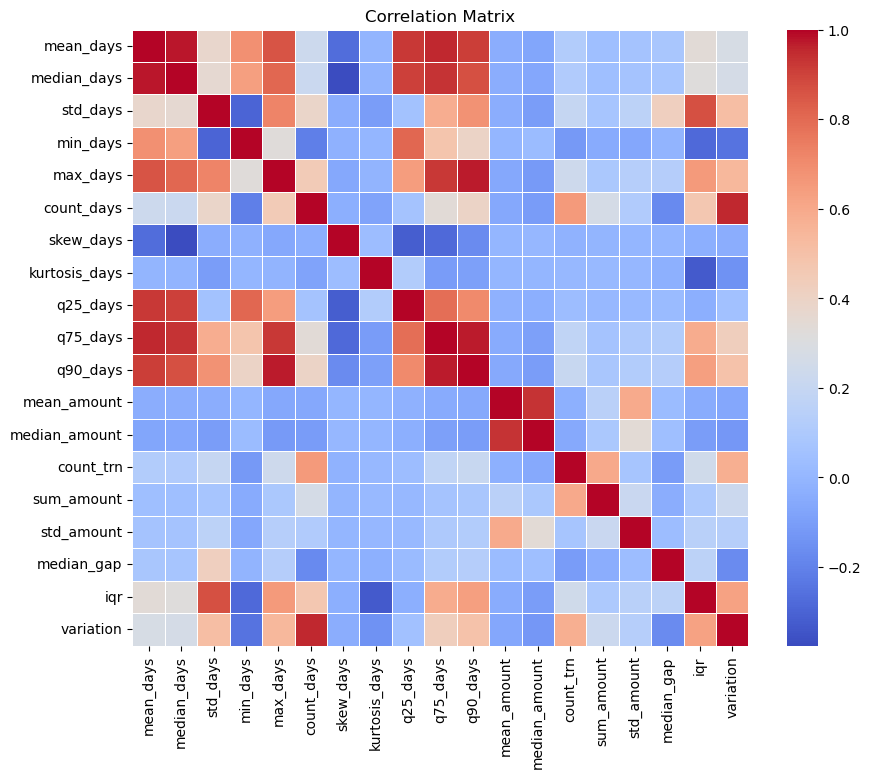

In [88]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)
plt.title("Correlation Matrix")
plt.show()

In [89]:
#df_cluster = df_cluster.sample(170000)

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [91]:
features = df_cluster.drop(columns=['payer_id', 'mean_days', 'std_days', 'min_days', 'median_days', 'skew_days', 'max_days', 'count_trn', 'std_amount', 'median_amount', 'kurtosis_days', 'q25_days', 'q75_days', 'variation'])

In [92]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

In [93]:
features.head()

,count_days,q90_days,mean_amount,sum_amount,median_gap,iqr
0,44,230.958450,87691.176471,5963000.0,0.896098,63.927816
1,6,106.665221,102500.000000,615000.0,7.147623,92.950577
2,12,163.522427,70769.230769,920000.0,11.540681,65.164710
3,25,68.887924,53715.909091,2363500.0,0.843067,33.650287
4,1,264.938804,120000.000000,120000.0,0.000000,0.000000


In [94]:
bic = []
for k in range(1, 10):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(normalized_data)
    bic.append(gmm.bic(normalized_data))

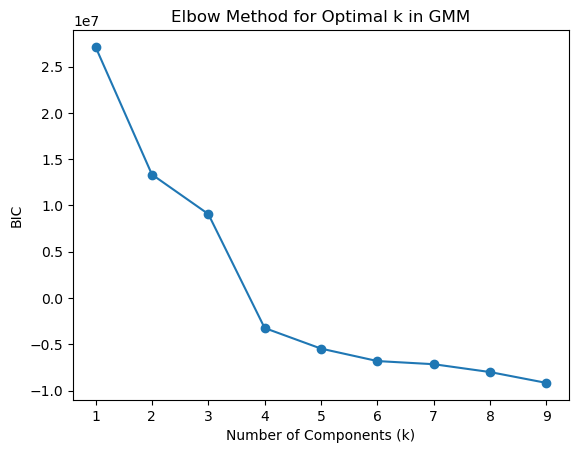

In [95]:
plt.plot(range(1, 10), bic, marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('BIC')
plt.title('Elbow Method for Optimal k in GMM')
plt.show()

In [54]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(3, 8):  
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(normalized_data)
    labels = gmm.predict(normalized_data)
    score = silhouette_score(normalized_data, labels)
    silhouette_scores.append(score)

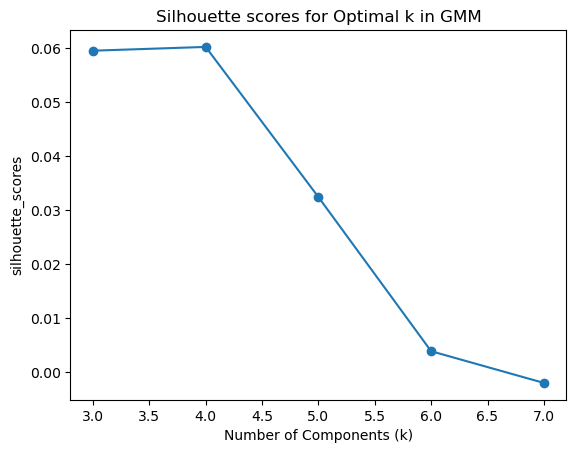

In [55]:
plt.plot(range(3, 8), silhouette_scores, marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('silhouette_scores')
plt.title('Silhouette scores for Optimal k in GMM')
plt.show()

In [96]:
gmm = GaussianMixture(n_components=4, random_state=42) 
df_cluster['cluster'] = gmm.fit_predict(normalized_data)

In [97]:
df_cluster.groupby('cluster')['payer_id'].count()/df_cluster['payer_id'].count()

cluster
0    0.399310
1    0.175447
2    0.331831
3    0.093412
Name: payer_id, dtype: float64

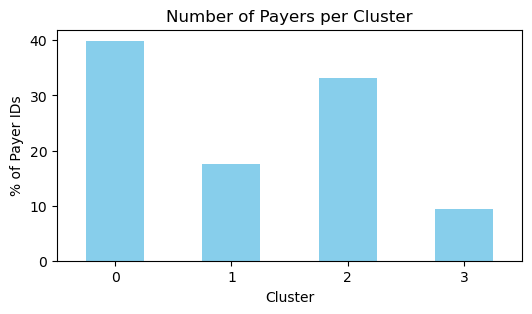

In [111]:
cluster_counts = df_cluster.groupby('cluster')['payer_id'].count()/df_cluster['payer_id'].count()*100
plt.figure(figsize=(6, 3))
cluster_counts.plot(kind='bar', color='skyblue', title='Number of Payers per Cluster')

plt.xlabel('Cluster')
plt.ylabel('% of Payer IDs')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.show()

In [113]:
df_cluster.groupby('cluster')['sum_amount'].sum()/df_cluster['sum_amount'].sum()*100

cluster
0    36.079108
1     0.976560
2     5.665195
3    57.279137
Name: sum_amount, dtype: float64

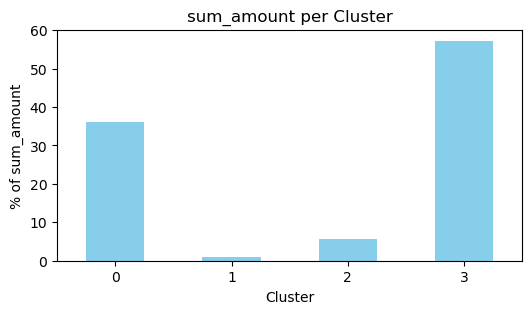

In [110]:
cluster_counts = df_cluster.groupby('cluster')['sum_amount'].sum()/df_cluster['sum_amount'].sum()*100
plt.figure(figsize=(6, 3))
cluster_counts.plot(kind='bar', color='skyblue', title='sum_amount per Cluster')

plt.xlabel('Cluster')
plt.ylabel('% of sum_amount')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.show()

In [100]:
df_cluster.columns

Index(['payer_id', 'mean_days', 'median_days', 'std_days', 'min_days',
       'max_days', 'count_days', 'skew_days', 'kurtosis_days', 'q25_days',
       'q75_days', 'q90_days', 'mean_amount', 'median_amount', 'count_trn',
       'sum_amount', 'std_amount', 'median_gap', 'iqr', 'variation',
       'cluster'],
      dtype='object')

In [101]:
col_list = ['median_days', 'std_days', 'min_days',
       'max_days', 'count_days', 'q25_days', 'q90_days', 
       'mean_amount', 'median_amount', 'count_trn', 'sum_amount',
       'median_gap', 'iqr']

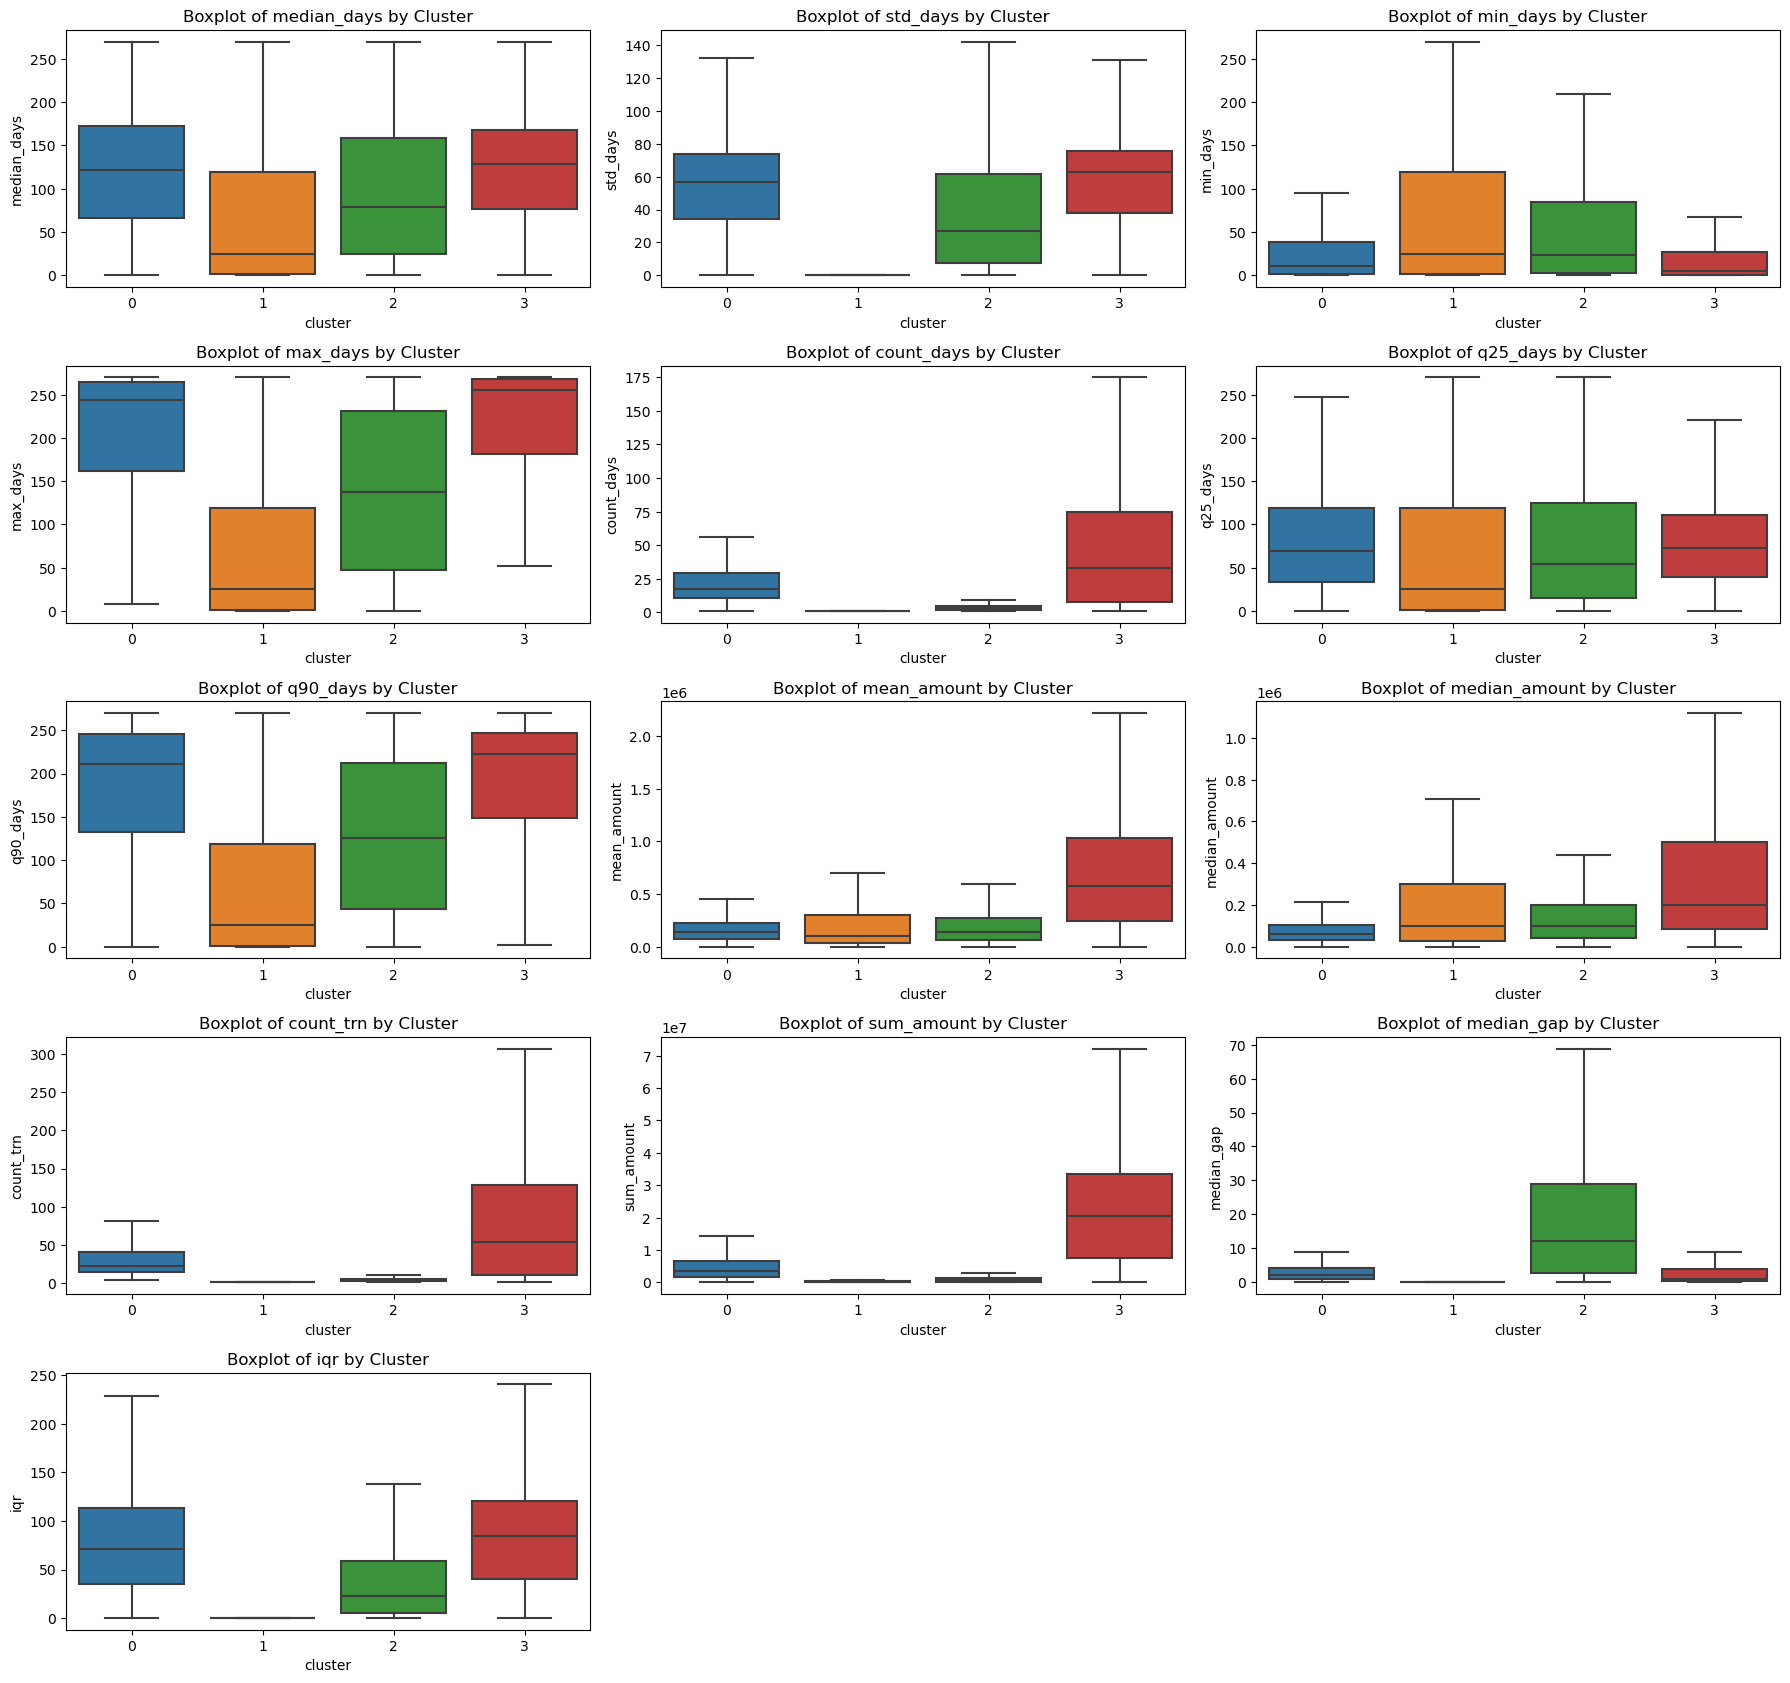

In [102]:
plt.figure(figsize=(18, 40))

# Create boxplots for each feature
for i, column in enumerate(col_list):
    plt.subplot(12, 3, i + 1)
    sns.boxplot(x='cluster', y=column, data=df_cluster, palette='Set2', showfliers=False)
    plt.title(f'Boxplot of {column} by Cluster')

plt.tight_layout()
plt.show()

In [103]:
col_list2 = ['count_days', 'mean_amount', 'sum_amount', 'median_gap', 'iqr', 'cluster']
df_subset = df_cluster[col_list2]

C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

<Figure size 1000x1000 with 0 Axes>

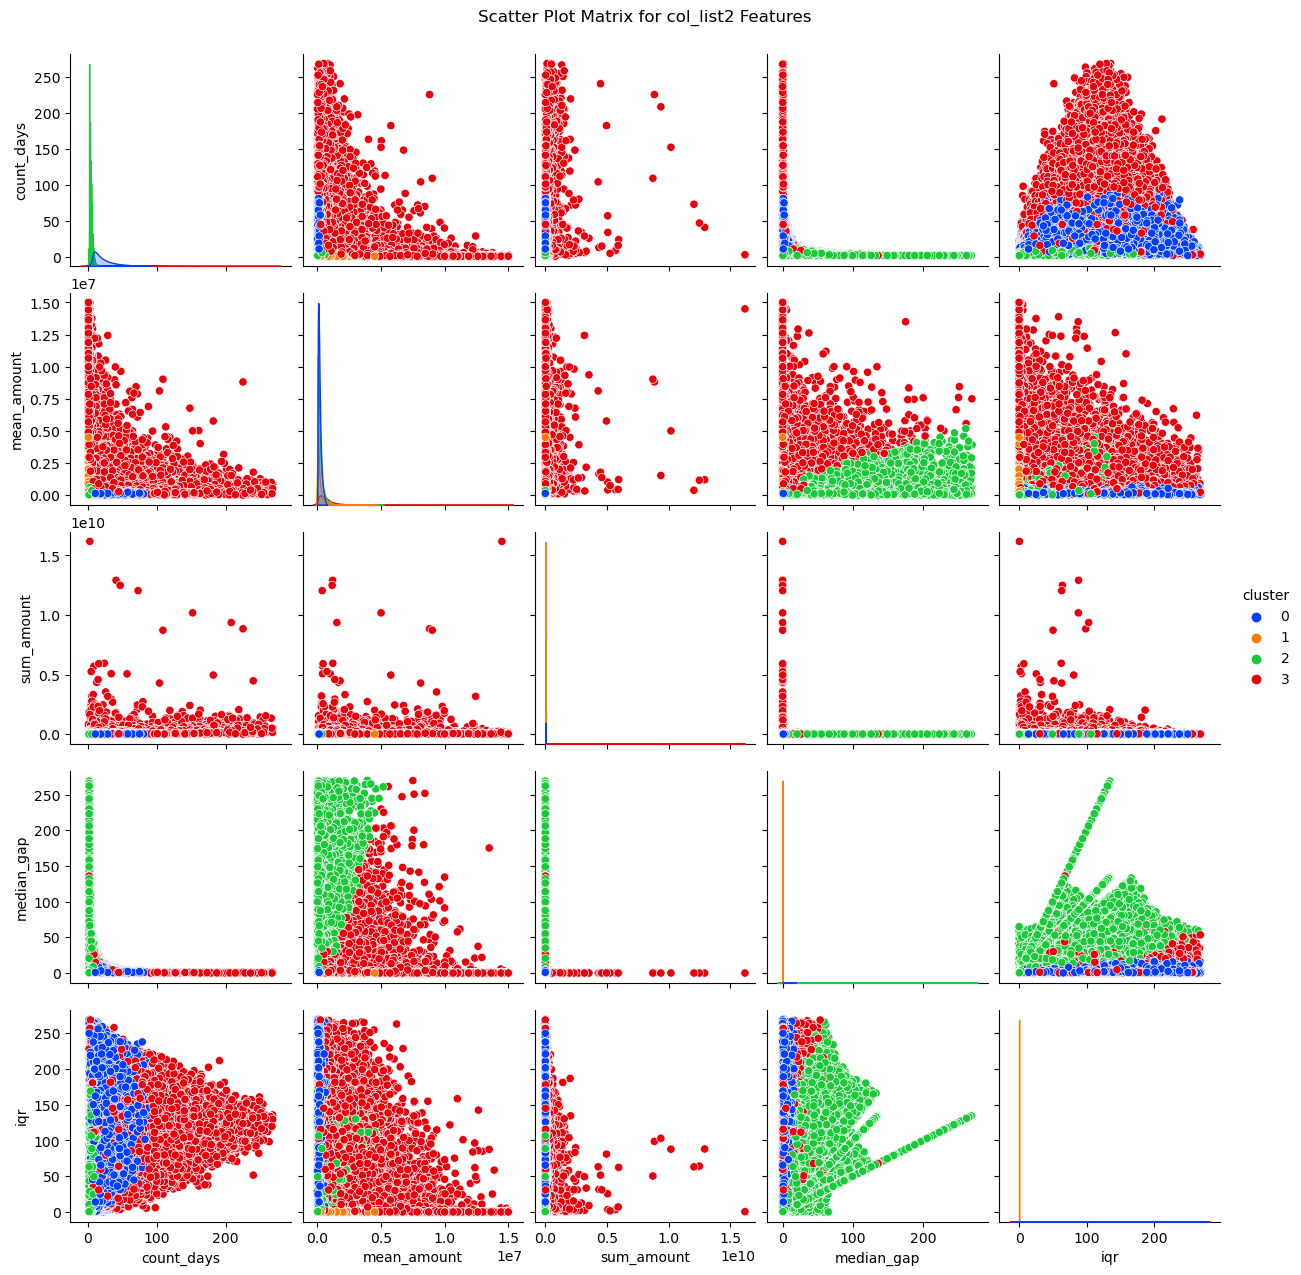

In [104]:
plt.figure(figsize=(10, 10))
sns.pairplot(df_subset, hue='cluster', palette = 'bright')
plt.suptitle('Scatter Plot Matrix for col_list2 Features', y=1.02)
plt.show()

In [106]:
cluster_mapping = {0: 'standard', 1: 'one_timer', 2: 'low', 3: 'top'}
df_cluster['cluster_name'] = df_cluster['cluster'].map(cluster_mapping).fillna('unknown')

In [108]:
df_cluster.to_csv('df_cluster.csv', index = False)

## Importing clusters

In [4]:
clusters = pd.read_csv('df_cluster.csv')

## Registration

In [5]:
reg = pd.read_sql("""
                select *
                from payme_sandbox.p2p_user_activation_reg
                """, con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_27976\4031718763.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reg = pd.read_sql("""


In [6]:
reg['date_'] = pd.to_datetime(reg['date_'])

In [7]:
reg['day_of_week'] = reg['date_'].dt.dayofweek

In [8]:
conditions = [
    reg['distance_km'] < 15,
    reg['distance_km'] >= 15 
]
values = [1, 2]

reg['tashkent'] = np.select(conditions, values, default=0)

In [9]:
reg_c = pd.merge(reg, clusters[['payer_id', 'cluster_name']], how = 'inner', left_on = '_id', right_on = 'payer_id').drop(columns = ['payer_id'])

In [10]:
reg_cl = pd.get_dummies(reg_c, columns=['cluster_name'], dtype = 'int')
reg_cl['cluster_name'] = reg_c['cluster_name']

In [11]:
reg_cl_age = reg_cl[(reg_cl.age >=14) & (reg_cl.age < 91)]

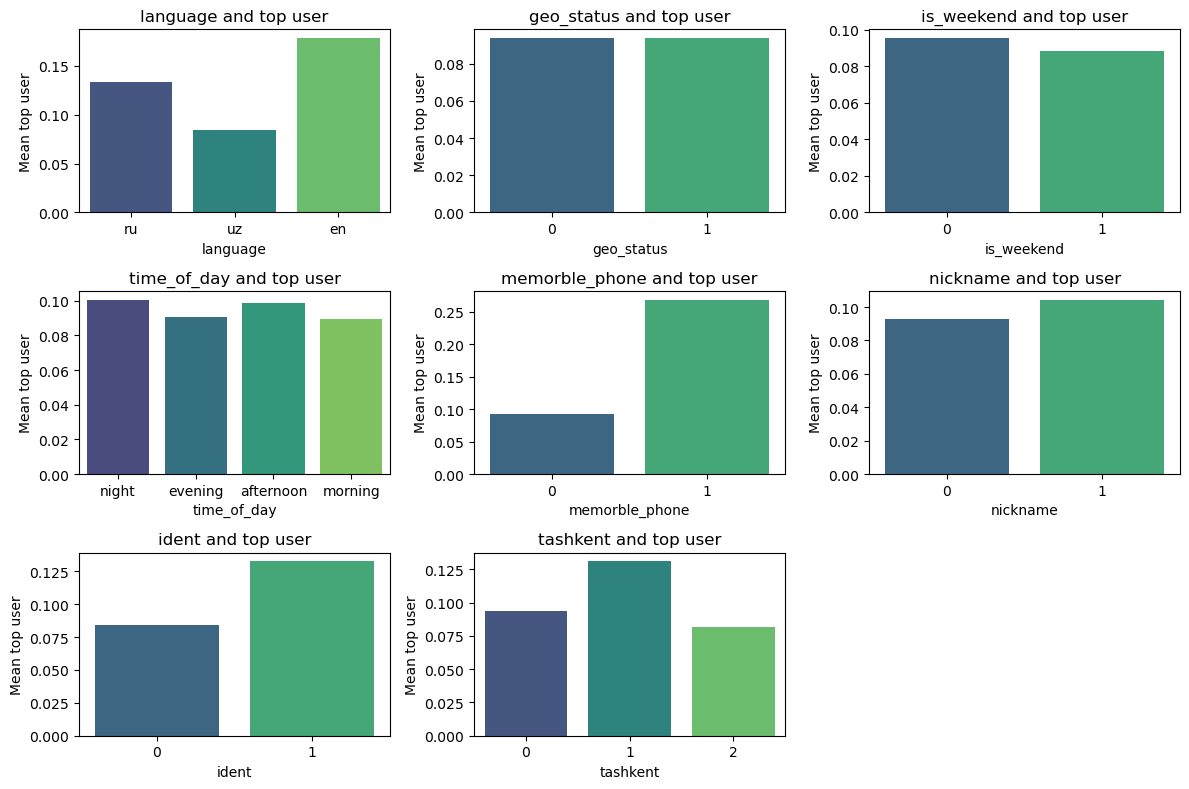

In [12]:
independent_features = ['language', 'geo_status', 'is_weekend', 'time_of_day', 'memorble_phone', 'nickname', 'ident', 'tashkent']

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Loop through each independent feature to create a bar plot
for i, feature in enumerate(independent_features):
    plt.subplot(3, 3, i+1)  # Create a subplot for each feature
    sns.barplot(x=feature, y='cluster_name_top', data=reg_cl, errorbar=None, palette='viridis')
    
    plt.title(f'{feature} and top user')
    plt.ylabel('Mean top user')  # Label the y-axis

plt.tight_layout()  # Adjust subplots to fit into figure area
plt.show()

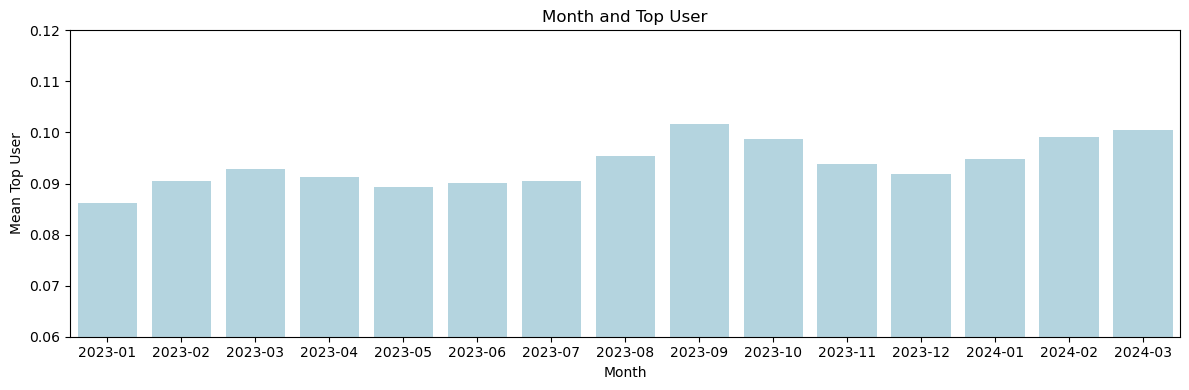

In [13]:
sorted_months = sorted(reg_cl['month_'].unique())

# Plotting the relationship between 'month_' and 'cluster_name_top'
plt.figure(figsize=(12, 4))

sns.barplot(
    x='month_', 
    y='cluster_name_top', 
    data=reg_cl, 
    order=sorted_months, 
    errorbar=None, 
    color='lightblue'  # Set all bars to light blue
)

plt.title('Month and Top User')
plt.xlabel('Month')  # Label the x-axis
plt.ylabel('Mean Top User')  # Label the y-axis

# Set y-axis limits
plt.ylim(0.06, 0.12)

plt.tight_layout()  # Adjust layout for better appearance
plt.show()

In [14]:
reg_cl.head()

,_id,date_,month_,language,geo_status,is_weekend,time_of_day,memorble_phone,distance_km,nickname,ident,age,day_of_week,tashkent,cluster_name_low,cluster_name_one_timer,cluster_name_standard,cluster_name_top,cluster_name
0,64498cd5ef0248f02c9e9486,2023-04-26 20:43:01.093000+00:00,2023-04,ru,1,0,night,0,2.623050,0,1,42.0,2,1,0,0,1,0,standard
1,6487237a661951ee14d29203,2023-06-12 13:54:02.002000+00:00,2023-06,ru,0,0,evening,0,NaN,0,0,NaN,0,0,1,0,0,0,low
2,658d5febd33c5a1885002ef0,2023-12-28 11:45:47.982000+00:00,2023-12,uz,0,0,afternoon,0,NaN,1,1,24.0,3,0,0,0,1,0,standard
3,63ef15da31ed260f6bf157b6,2023-02-17 05:51:22.093000+00:00,2023-02,uz,1,0,morning,0,7.334055,0,1,36.0,4,1,1,0,0,0,low
4,64aa9be5ac842ce172bdf3ce,2023-07-09 11:37:09.305000+00:00,2023-07,uz,0,1,afternoon,0,NaN,0,0,NaN,6,0,0,0,1,0,standard


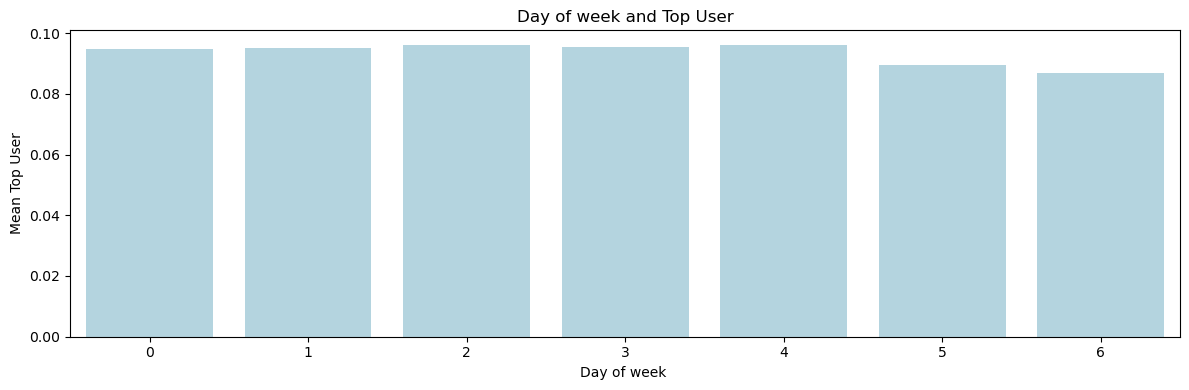

In [15]:
plt.figure(figsize=(12, 4))

sns.barplot(
    x='day_of_week', 
    y='cluster_name_top', 
    data=reg_cl, 
    errorbar=None, 
    color='lightblue'  # Set all bars to light blue
)

plt.title('Day of week and Top User')
plt.xlabel('Day of week ')  # Label the x-axis
plt.ylabel('Mean Top User')  # Label the y-axis

# Set y-axis limits
#plt.ylim(0, 0.12)

plt.tight_layout()  # Adjust layout for better appearance
plt.show()

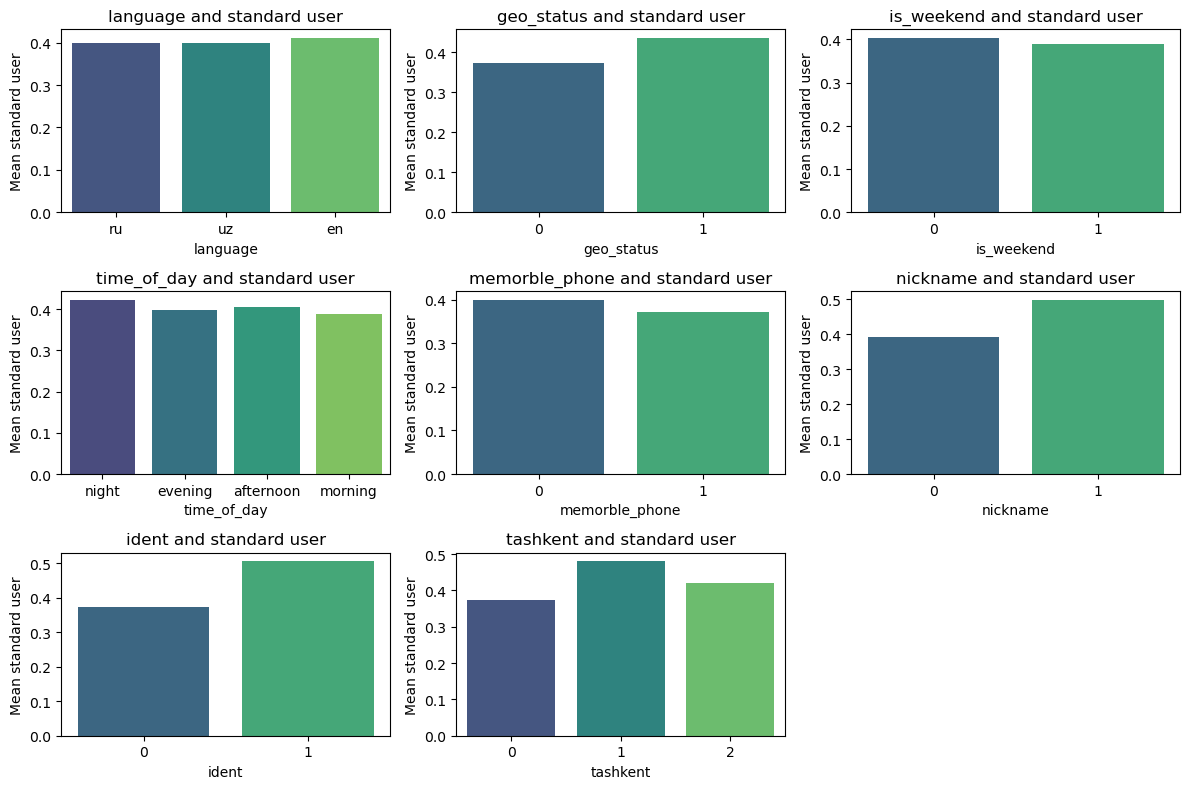

In [16]:
independent_features = ['language', 'geo_status', 'is_weekend', 'time_of_day', 'memorble_phone', 'nickname', 'ident', 'tashkent']

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Loop through each independent feature to create a bar plot
for i, feature in enumerate(independent_features):
    plt.subplot(3, 3, i+1)  # Create a subplot for each feature
    sns.barplot(x=feature, y='cluster_name_standard', data=reg_cl, errorbar=None, palette='viridis')
    
    plt.title(f'{feature} and standard user')
    plt.ylabel('Mean standard user')  # Label the y-axis

plt.tight_layout()  # Adjust subplots to fit into figure area
plt.show()

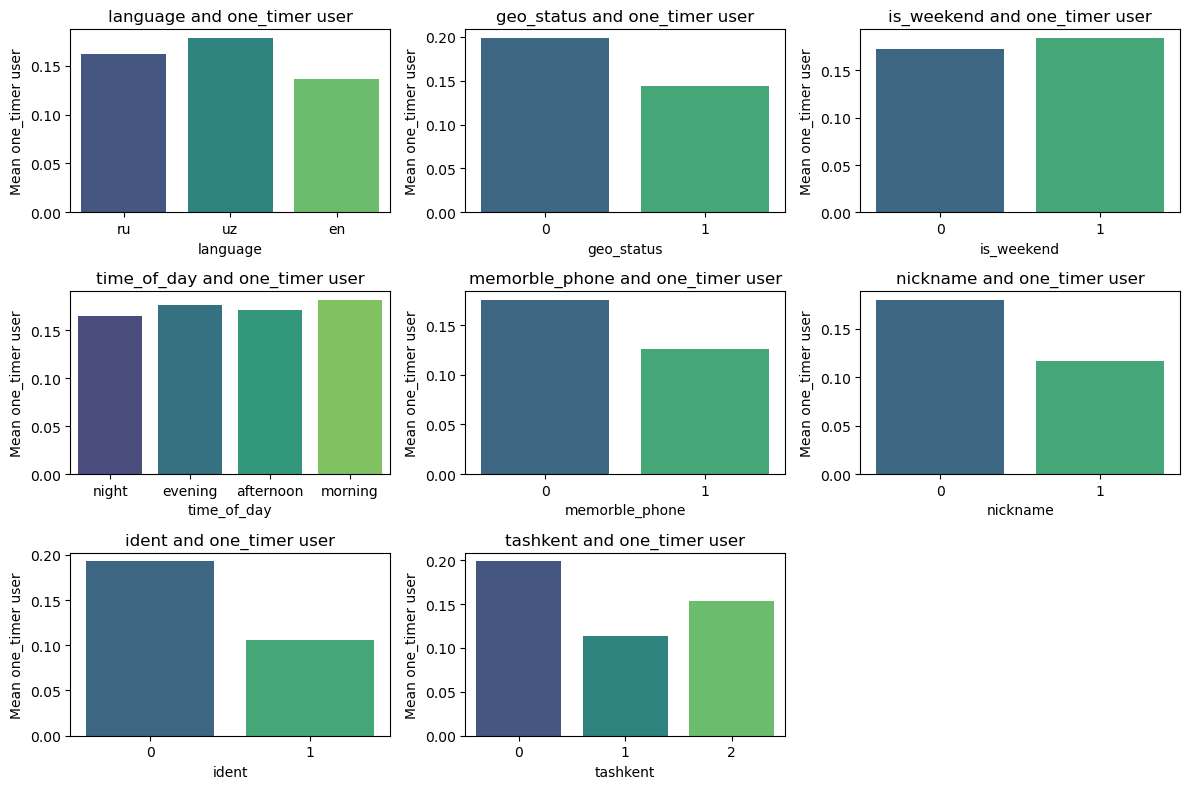

In [17]:
independent_features = ['language', 'geo_status', 'is_weekend', 'time_of_day', 'memorble_phone', 'nickname', 'ident', 'tashkent']

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Loop through each independent feature to create a bar plot
for i, feature in enumerate(independent_features):
    plt.subplot(3, 3, i+1)  # Create a subplot for each feature
    sns.barplot(x=feature, y='cluster_name_one_timer', data=reg_cl, errorbar=None, palette='viridis')
    
    plt.title(f'{feature} and one_timer user')
    plt.ylabel('Mean one_timer user')  # Label the y-axis

plt.tight_layout()  # Adjust subplots to fit into figure area
plt.show()

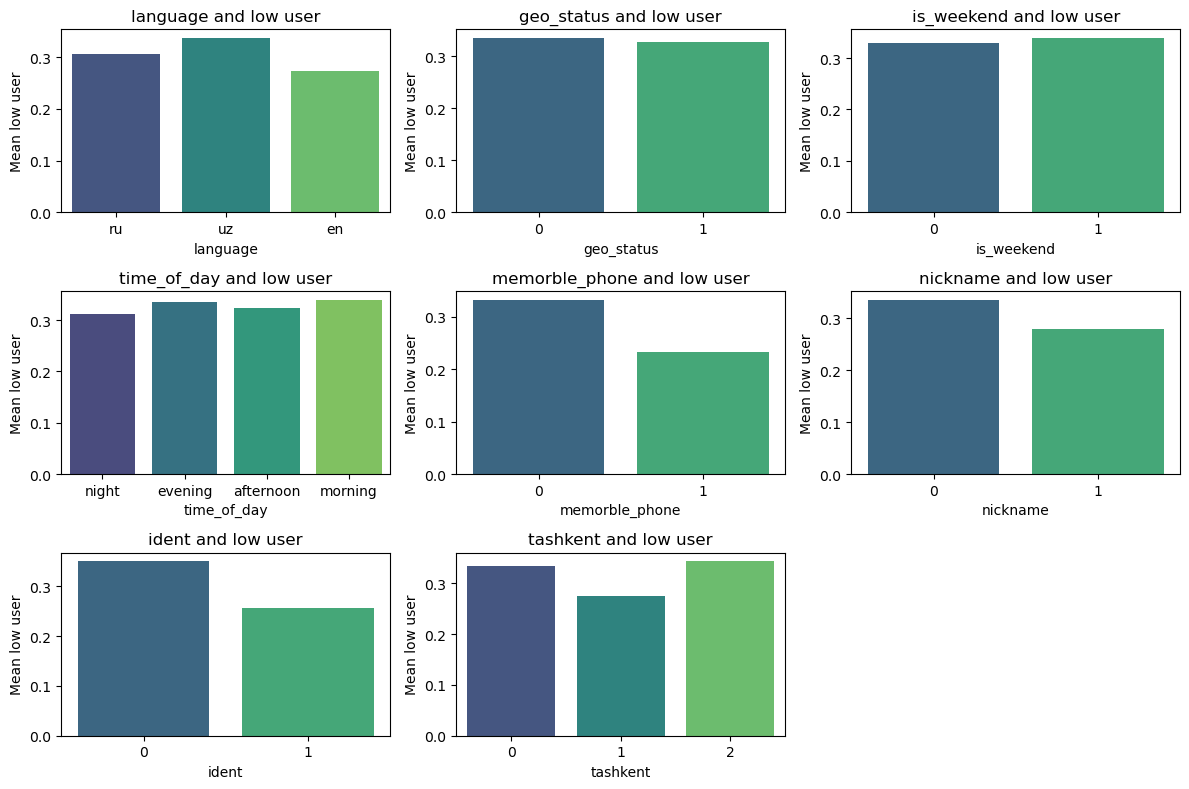

In [18]:
independent_features = ['language', 'geo_status', 'is_weekend', 'time_of_day', 'memorble_phone', 'nickname', 'ident', 'tashkent']

# Set up the plotting area
plt.figure(figsize=(12, 8))

# Loop through each independent feature to create a bar plot
for i, feature in enumerate(independent_features):
    plt.subplot(3, 3, i+1)  # Create a subplot for each feature
    sns.barplot(x=feature, y='cluster_name_low', data=reg_cl, errorbar=None, palette='viridis')
    
    plt.title(f'{feature} and low user')
    plt.ylabel('Mean low user')  # Label the y-axis

plt.tight_layout()  # Adjust subplots to fit into figure area
plt.show()

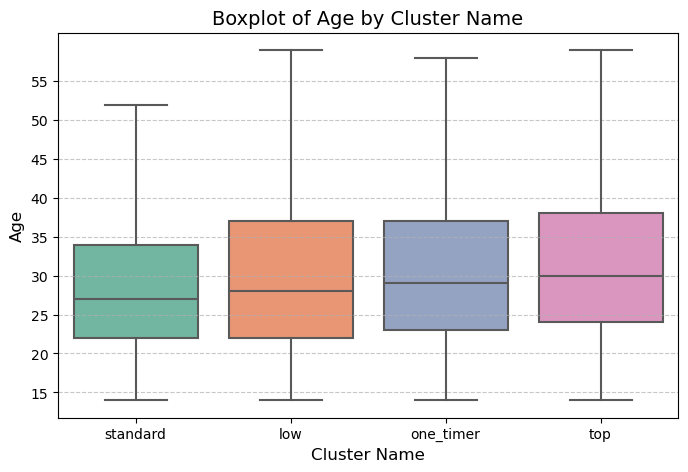

In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=reg_cl_age, x='cluster_name', y='age', palette='Set2', showfliers=False)

yticks = np.arange(15, 60, 5) 
plt.yticks(yticks)

# Customize the plot.
plt.title('Boxplot of Age by Cluster Name', fontsize=14)
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Devices

In [20]:
dev = pd.read_sql("""
select *
from
(
select *, row_number() over (partition by user_id order by date_) rn
from
    (
    select user_id, lower(regexp_replace(split_part(display, ' ', 1), '[0-9,]', '', 'g')) model, lower(agent_os_name) os, raw_data -> 'agent' -> 'app' ->> 'theme' theme, date date_
    from ods__mdbmn__payme.devices
    union all
    select user_id, lower(regexp_replace(split_part(display, ' ', 1), '[0-9,]', '', 'g')) model, lower(agent_os_name) os, raw_data -> 'agent' -> 'app' ->> 'theme' theme, date_time date_
    from ods__mdbmn__payme.devices_archive
    ) d1
) d2
where rn = 1
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_27976\4223986124.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dev = pd.read_sql("""


In [21]:
dev_cl = pd.merge(dev, clusters[['payer_id', 'cluster_name']], how = 'inner', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

dev_cld = pd.get_dummies(dev_cl, columns=['cluster_name'], dtype = 'int')
dev_cld['cluster_name'] = dev_cl['cluster_name']

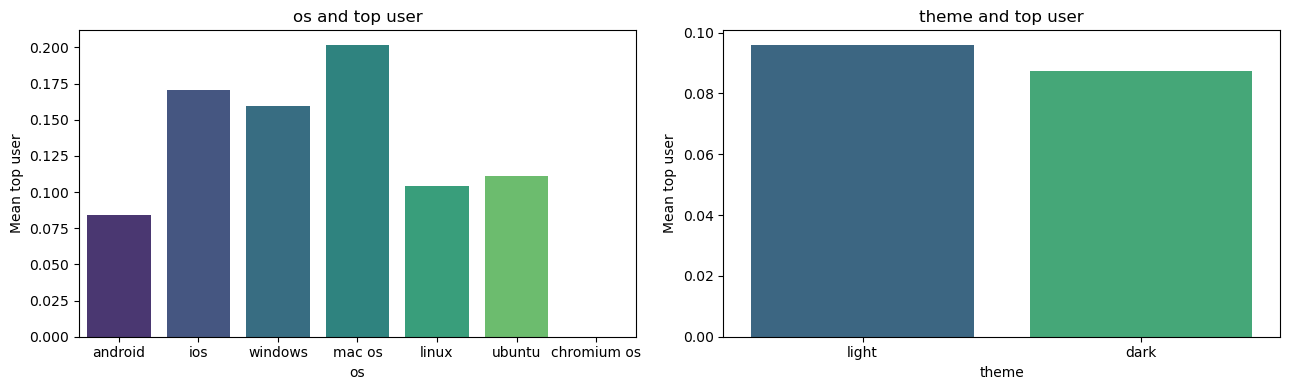

In [22]:
independent_features = ['os', 'theme']

# Set up the plotting area
plt.figure(figsize=(13, 4))

# Loop through each independent feature to create a bar plot
for i, feature in enumerate(independent_features):
    plt.subplot(1, 2, i+1)  # Create a subplot for each feature
    sns.barplot(x=feature, y='cluster_name_top', data=dev_cld, errorbar=None, palette='viridis')
    
    plt.title(f'{feature} and top user')
    plt.ylabel('Mean top user')  # Label the y-axis

plt.tight_layout()  # Adjust subplots to fit into figure area
plt.show()

In [23]:
dev_cld.groupby('os')['user_id'].count()

os
android        1493890
chromium os          1
ios             175025
linux              134
mac os             228
ubuntu               9
windows           5278
Name: user_id, dtype: int64

In [24]:
models = dev_cld.groupby('model')['user_id'].count().reset_index().sort_values('user_id', ascending = False).head(10)['model']

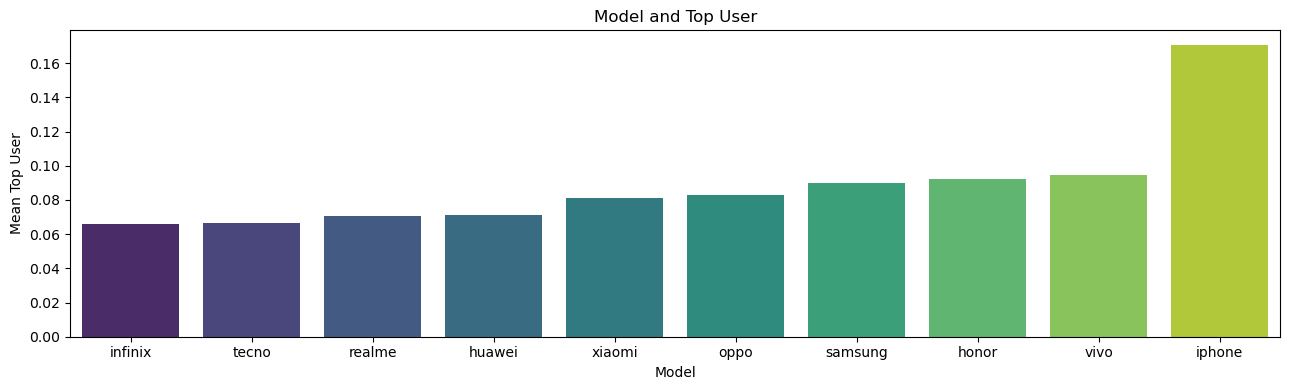

In [25]:
sorted_data = (
    dev_cld[dev_cld['model'].isin(models)]
    .groupby('model', as_index=False)['cluster_name_top']
    .mean()
    .sort_values(by='cluster_name_top')
)

plt.figure(figsize=(13, 4))
sns.barplot(
    x='model', 
    y='cluster_name_top', 
    data=sorted_data, 
    errorbar=None, 
    palette='viridis'
)

plt.title(f'Model and Top User')
plt.ylabel('Mean Top User')
plt.xlabel('Model')

plt.tight_layout()  
plt.show()

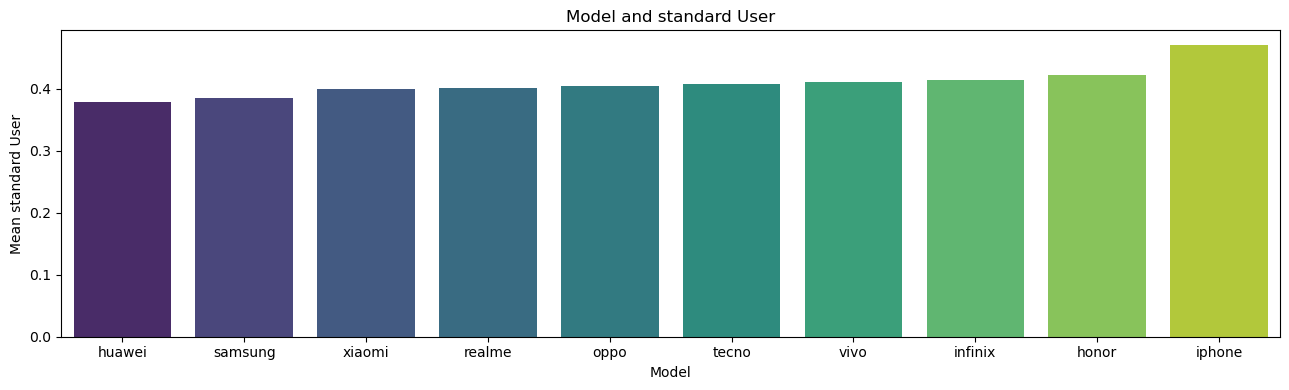

In [26]:
sorted_data = (
    dev_cld[dev_cld['model'].isin(models)]
    .groupby('model', as_index=False)['cluster_name_standard']
    .mean()
    .sort_values(by='cluster_name_standard')
)

plt.figure(figsize=(13, 4))
sns.barplot(
    x='model', 
    y='cluster_name_standard', 
    data=sorted_data, 
    errorbar=None, 
    palette='viridis'
)

plt.title(f'Model and standard User')
plt.ylabel('Mean standard User')
plt.xlabel('Model')

plt.tight_layout()  
plt.show()

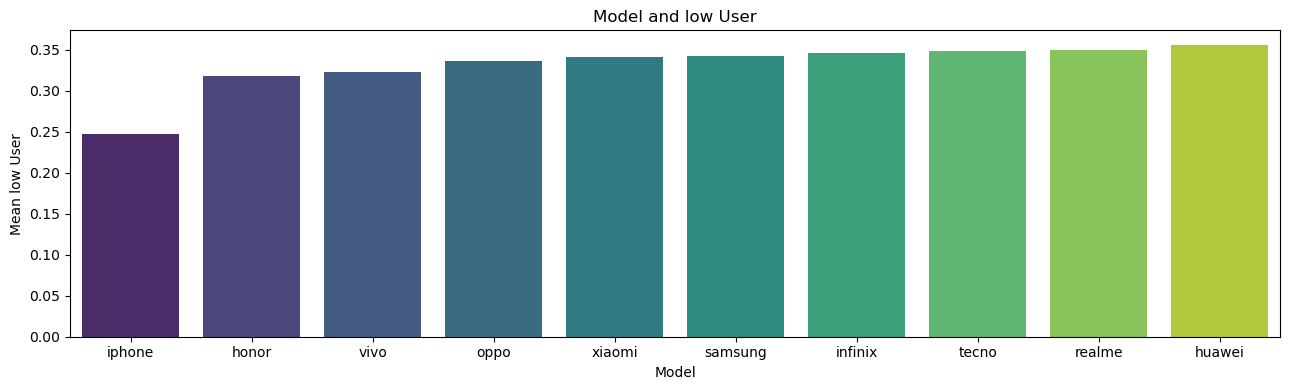

In [27]:
sorted_data = (
    dev_cld[dev_cld['model'].isin(models)]
    .groupby('model', as_index=False)['cluster_name_low']
    .mean()
    .sort_values(by='cluster_name_low')
)

plt.figure(figsize=(13, 4))
sns.barplot(
    x='model', 
    y='cluster_name_low', 
    data=sorted_data, 
    errorbar=None, 
    palette='viridis'
)

plt.title(f'Model and low User')
plt.ylabel('Mean low User')
plt.xlabel('Model')

plt.tight_layout()  
plt.show()

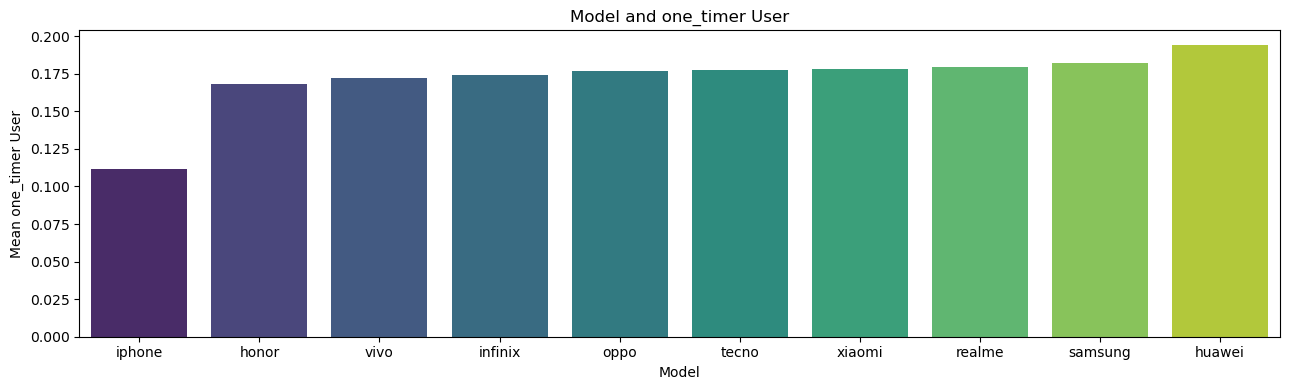

In [28]:
sorted_data = (
    dev_cld[dev_cld['model'].isin(models)]
    .groupby('model', as_index=False)['cluster_name_one_timer']
    .mean()
    .sort_values(by='cluster_name_one_timer')
)

plt.figure(figsize=(13, 4))
sns.barplot(
    x='model', 
    y='cluster_name_one_timer', 
    data=sorted_data, 
    errorbar=None, 
    palette='viridis'
)

plt.title(f'Model and one_timer User')
plt.ylabel('Mean one_timer User')
plt.xlabel('Model')

plt.tight_layout()  
plt.show()

## Sessions

In [29]:
ses = pd.read_sql("""
        select user_id, session_date_1, session_date_2,
            extract(epoch from (session_date_2 - session_date_1))/60/60 second_session_hours,
            extract(epoch from (session_date_5 - session_date_1))/60/60/24 fifth_session_days,
            extract(epoch from (session_date_10 - session_date_1))/60/60/24 tenth_session_days,
            case when session_date_5 is null then 0 else 1 end fifth_session_flg,
            case when session_date_10 is null then 0 else 1 end tenth_session_flg,
            returned_next_day,
            day_sessions::numeric/(day_sessions + night_sessions)::numeric day_sessions_share
        from payme_sandbox.p2p_user_activation_sessions_
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_27976\647131889.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ses = pd.read_sql("""


In [30]:
week = pd.read_sql("""
        select *
        from payme_sandbox.p2p_user_activation_sessions_day_of_week
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_27976\2400564199.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  week = pd.read_sql("""


In [31]:
hour = pd.read_sql("""
        select *
        from payme_sandbox.p2p_user_activation_sessions_hour_of_day
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_27976\4150690652.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hour = pd.read_sql("""


In [32]:
day = pd.read_sql("""
        select *
        from payme_sandbox.p2p_user_activation_sessions_day_of_month
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_27976\2654121714.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  day = pd.read_sql("""


In [33]:
ses_cl = pd.merge(ses, clusters[['payer_id', 'cluster_name']], how = 'inner', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

In [34]:
ses_cld = pd.get_dummies(ses_cl, columns=['cluster_name'], dtype = 'int')
ses_cld['cluster_name'] = ses_cl['cluster_name']

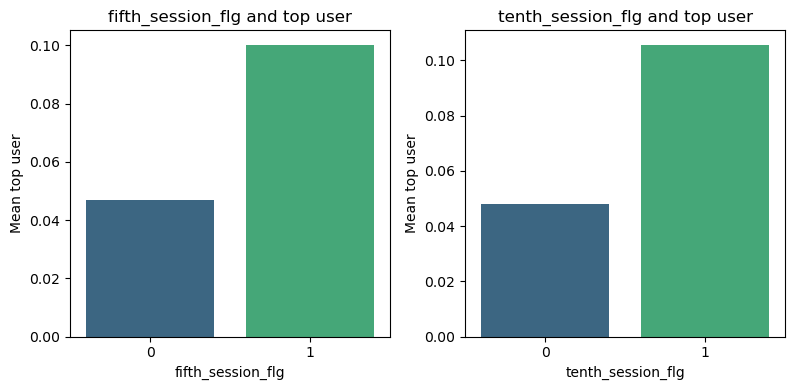

In [35]:
independent_features = ['fifth_session_flg', 'tenth_session_flg']

# Set up the plotting area
plt.figure(figsize=(12, 4))

# Loop through each independent feature to create a bar plot
for i, feature in enumerate(independent_features):
    plt.subplot(1, 3, i+1)  
    sns.barplot(x=feature, y='cluster_name_top', data=ses_cld, errorbar=None, palette='viridis')
    
    plt.title(f'{feature} and top user')
    plt.ylabel('Mean top user')  

plt.tight_layout()  
plt.show()

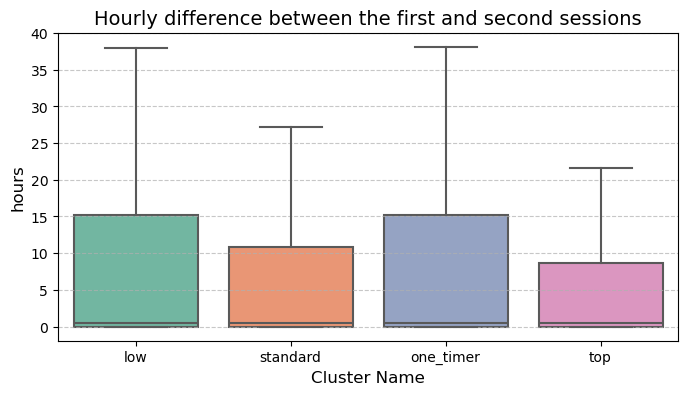

In [36]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=ses_cld.dropna(subset='second_session_hours'), x='cluster_name', y='second_session_hours', palette='Set2', showfliers=False)

# Customize the plot.
plt.title('Hourly difference between the first and second sessions', fontsize=14)
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('hours', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

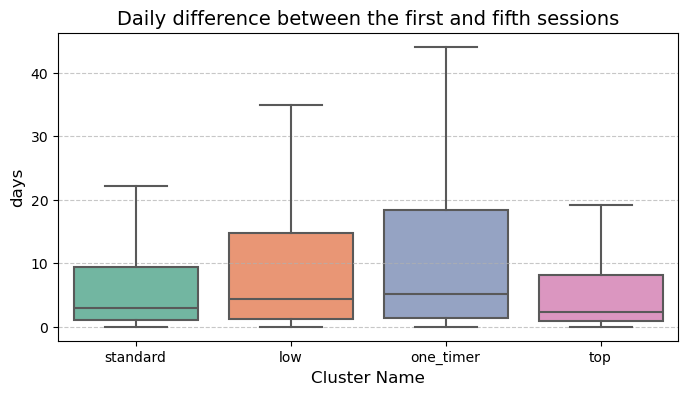

In [37]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=ses_cld.dropna(subset='fifth_session_days'), x='cluster_name', y='fifth_session_days', palette='Set2', showfliers=False)

# Customize the plot.
plt.title('Daily difference between the first and fifth sessions', fontsize=14)
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('days', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

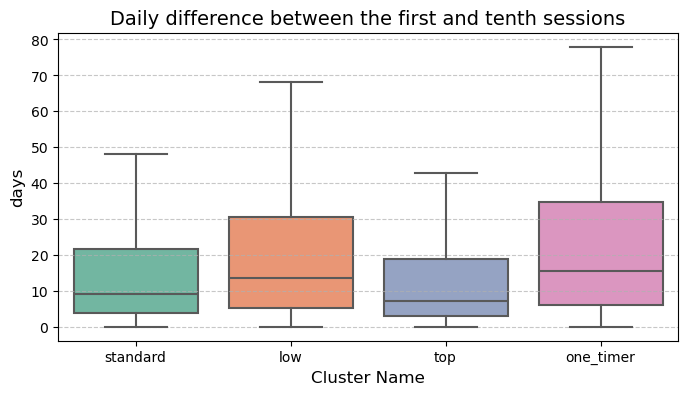

In [38]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=ses_cld.dropna(subset='tenth_session_days'), x='cluster_name', y='tenth_session_days', palette='Set2', showfliers=False)

# Customize the plot.
plt.title('Daily difference between the first and tenth sessions', fontsize=14)
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('days', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

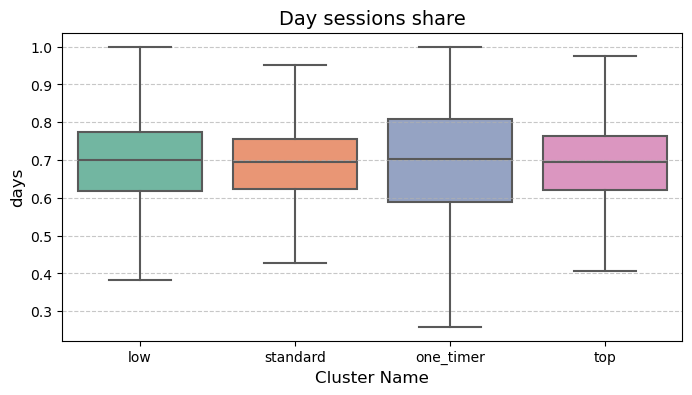

In [39]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=ses_cld, x='cluster_name', y='day_sessions_share', palette='Set2', showfliers=False)

# Customize the plot.
plt.title('Day sessions share', fontsize=14)
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('days', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.ylim(0.5, 0.9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [40]:
week_cl = pd.merge(week, clusters[['payer_id', 'cluster_name']], how = 'inner', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

In [41]:
week_cld = pd.get_dummies(week_cl, columns=['cluster_name'], dtype = 'int')
week_cld['cluster_name'] = week_cl['cluster_name']

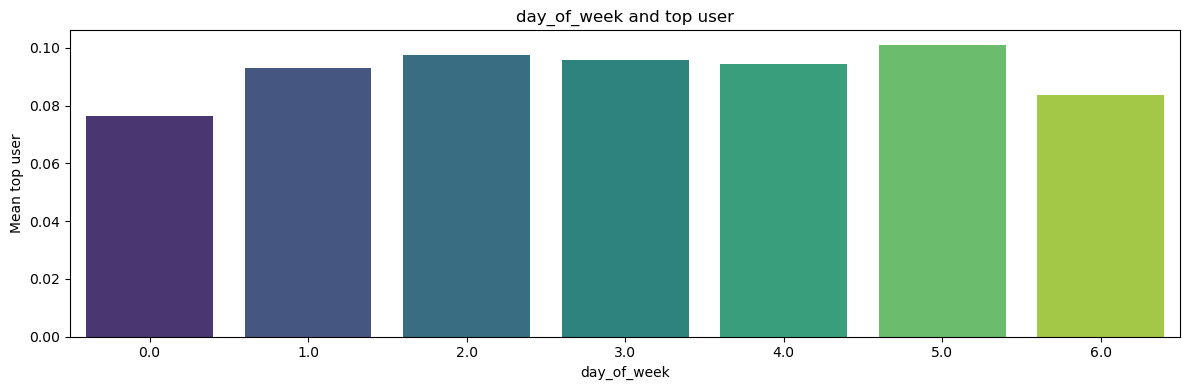

In [42]:
plt.figure(figsize=(12, 4))

sns.barplot(x='day_of_week', y='cluster_name_top', data=week_cld, errorbar=None, palette='viridis')

plt.title('day_of_week and top user')
plt.ylabel('Mean top user')  

plt.tight_layout()  
plt.show()

In [43]:
hour_cl = pd.merge(hour, clusters[['payer_id', 'cluster_name']], how = 'inner', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

In [44]:
hour_cld = pd.get_dummies(hour_cl, columns=['cluster_name'], dtype = 'int')
hour_cld['cluster_name'] = hour_cl['cluster_name']

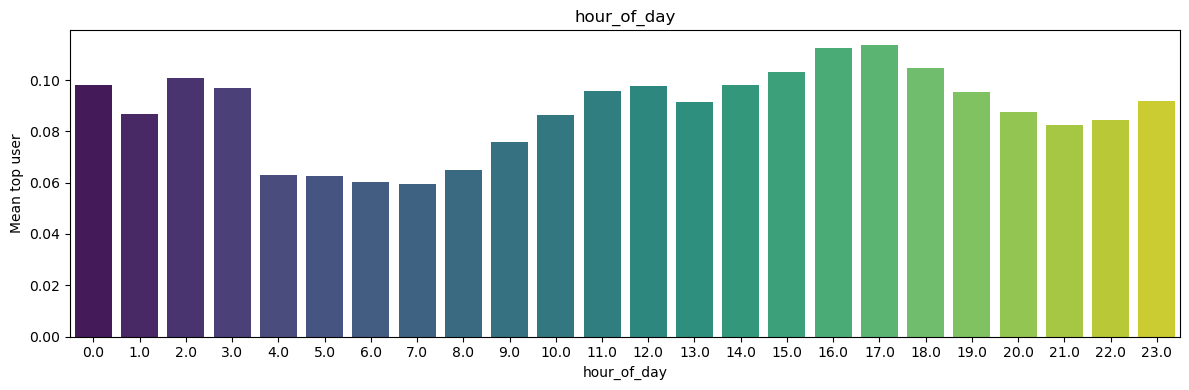

In [45]:
plt.figure(figsize=(12, 4))

sns.barplot(x='hour_of_day', y='cluster_name_top', data=hour_cld, errorbar=None, palette='viridis')

plt.title('hour_of_day')
plt.ylabel('Mean top user')  

plt.tight_layout()  
plt.show()

In [46]:
day

,user_id,day_of_month
0,644ebb475d6668c148d9d576,13.0
1,644eed5d7d4362c42c64bc91,23.0
2,644f1e39b336ec412dbcfd5f,2.0
3,644f405fd97c1b722dde4da8,29.0
4,644f511bd5284a45445996e2,18.0
...,...,...
3035917,6759a6b8ac070165cd0db2da,5.0
3035918,675e88e3c7b40bb6f9507ee8,24.0
3035919,676844fddff593eb55f1b3a3,22.0
3035920,676af8818e2dc772bf2e765b,25.0


In [47]:
day_cl = pd.merge(day, clusters[['payer_id', 'cluster_name']], how = 'inner', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

In [48]:
day_cld = pd.get_dummies(day_cl, columns=['cluster_name'], dtype = 'int')
day_cld['cluster_name'] = day_cl['cluster_name']

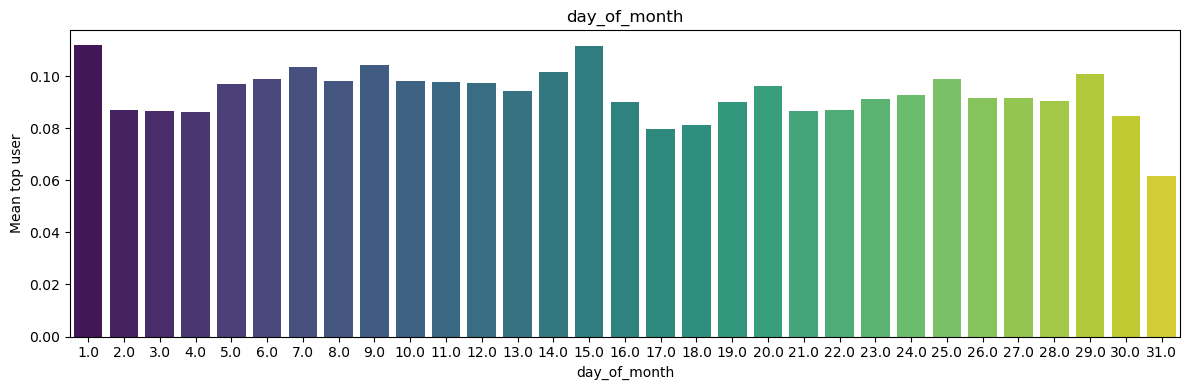

In [49]:
plt.figure(figsize=(12, 4))

sns.barplot(x='day_of_month', y='cluster_name_top', data=day_cld, errorbar=None, palette='viridis')

plt.title('day_of_month')
plt.ylabel('Mean top user')  

plt.tight_layout()  
plt.show()

In [50]:
cards = pd.read_sql("""
        select * from payme_sandbox.p2p_user_activation_cards
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_27976\3541958526.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cards = pd.read_sql("""


In [51]:
cards_cl = pd.merge(cards, clusters[['payer_id', 'cluster_name']], how = 'inner', left_on = 'user_id', right_on = 'payer_id').drop(columns = ['payer_id'])

In [52]:
cards_cld = pd.get_dummies(cards_cl, columns=['cluster_name'], dtype = 'int')
cards_cld['cluster_name'] = cards_cl['cluster_name']

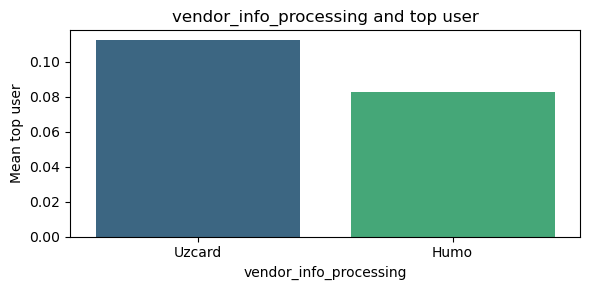

In [53]:
plt.figure(figsize=(6, 3))

sns.barplot(x='vendor_info_processing', y='cluster_name_top', data=cards_cld, errorbar=None, palette='viridis')

plt.title('vendor_info_processing and top user')
plt.ylabel('Mean top user')  

plt.tight_layout()  
plt.show()

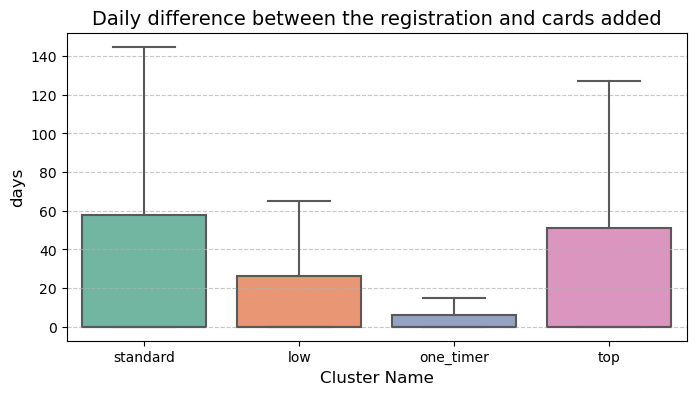

In [54]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=cards_cld, x='cluster_name', y='card_add_days', palette='Set2', showfliers=False)

# Customize the plot.
plt.title('Daily difference between the registration and cards added', fontsize=14)
plt.xlabel('Cluster Name', fontsize=12)
plt.ylabel('days', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [55]:
tran = pd.read_sql("""
        select * from payme_sandbox.p2p_user_activation_transactions
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_27976\2125530482.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tran = pd.read_sql("""


In [56]:
tran_cl = pd.merge(tran, clusters[['payer_id', 'cluster_name']], how = 'inner', on = 'payer_id')

In [59]:
tran_cld = pd.get_dummies(tran_cl, columns=['cluster_name'], dtype = 'int')
tran_cld['cluster_name'] = tran_cl['cluster_name']

In [60]:
cl_user_size = clusters.groupby('cluster_name')['payer_id'].nunique().reset_index().rename(columns = {'payer_id':'total_users'})

In [62]:
tran_cl_grouped = tran_cl.groupby(['cluster_name', 'tr_type']).agg({'payer_id': 'nunique', 'amount': 'sum'}).reset_index()

In [63]:
tran_cl_grouped = tran_cl_grouped.merge(cl_user_size, how = 'inner', on = 'cluster_name')

In [64]:
tran_cl_grouped['intersection_with_transfers'] = 100*tran_cl_grouped['payer_id'] / tran_cl_grouped['total_users']

In [65]:
tran_cl_grouped.tr_type.nunique()

24

C:\Users\MSI\AppData\Local\Temp\ipykernel_27976\1595503888.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


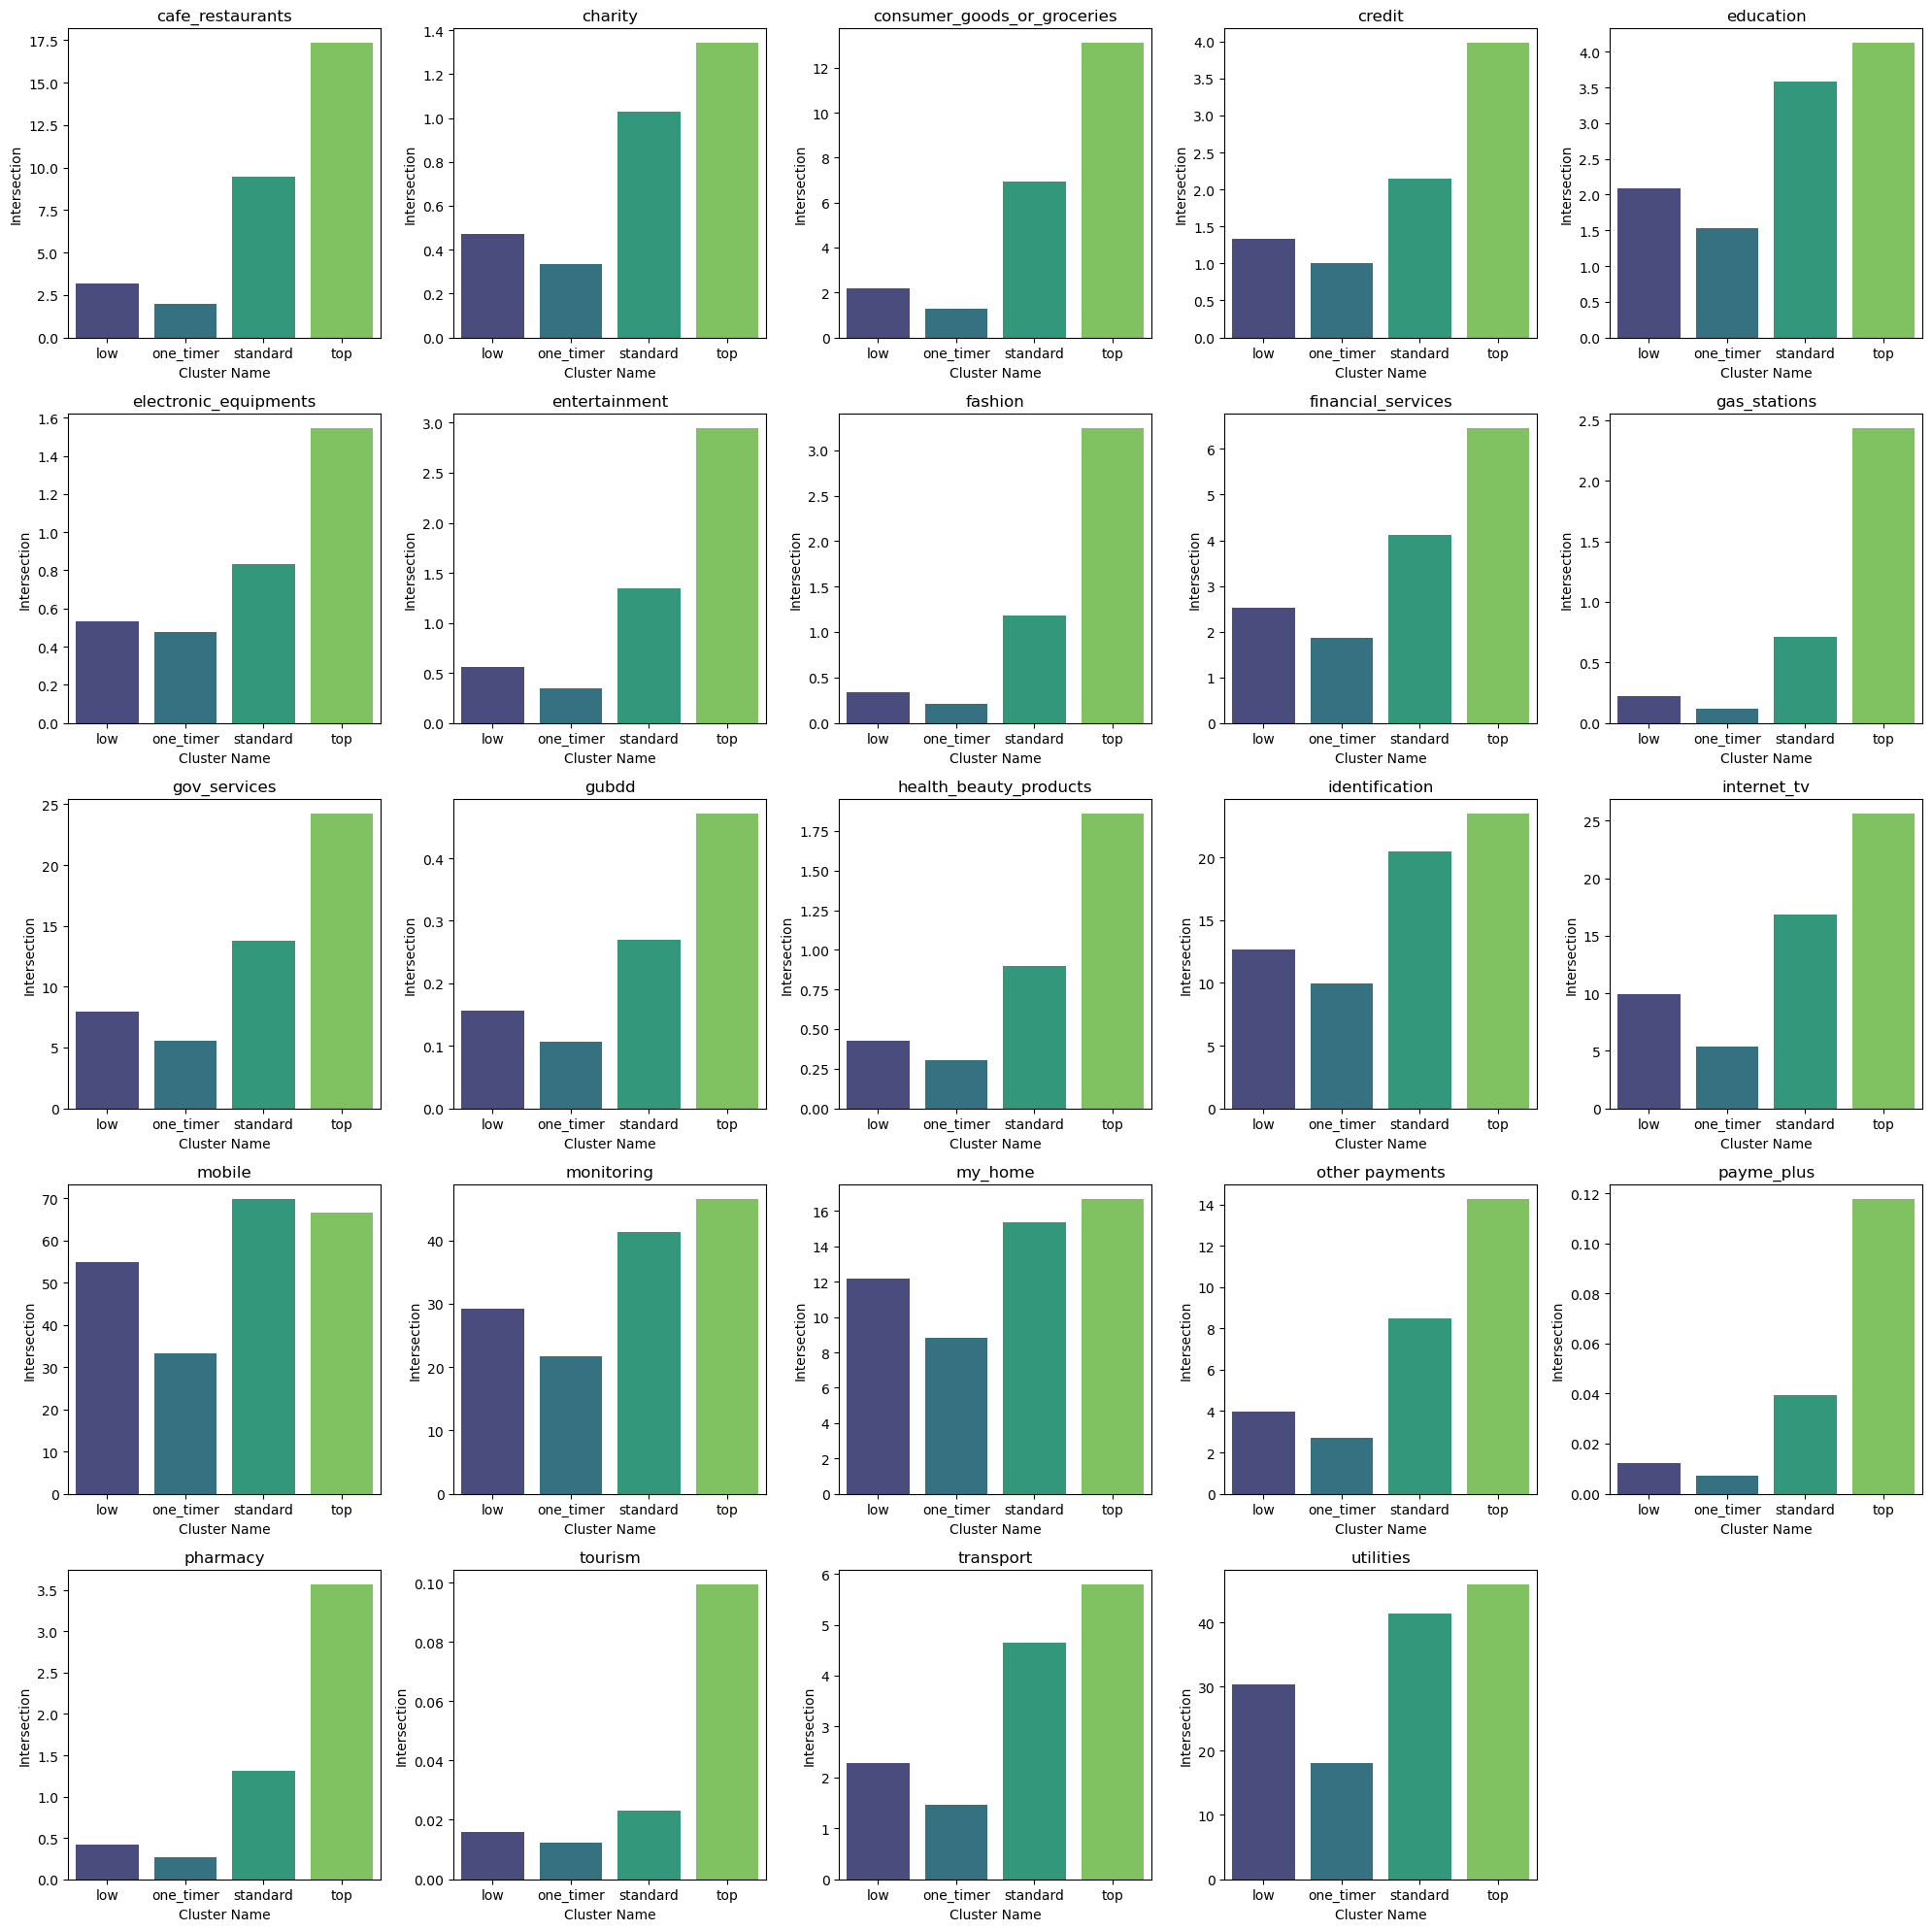

In [66]:
tr_types = tran_cl_grouped['tr_type'].unique()

# Number of subplots
num_tr_types = len(tr_types)
rows = (num_tr_types + 4) // 5  # Adjust rows dynamically for 5 columns
cols = 5  # Set columns to 5

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows), constrained_layout=True)
axes = axes.flatten()  # Flatten to easily iterate

# Plot each tr_type
for i, tr_type in enumerate(tr_types):
    ax = axes[i]
    data = tran_cl_grouped[tran_cl_grouped['tr_type'] == tr_type]
    sns.barplot(
        data=data,
        x='cluster_name',
        y='intersection_with_transfers',
        ax=ax,
        palette = 'viridis'
    )
    ax.set_title(tr_type)
    ax.set_xlabel('Cluster Name')
    ax.set_ylabel('Intersection')

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Final adjustments
plt.tight_layout()
plt.show()

In [69]:
tran_cl_grouped['volume_per_user'] = tran_cl_grouped['amount']/tran_cl_grouped['payer_id']

C:\Users\MSI\AppData\Local\Temp\ipykernel_27976\4026259695.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


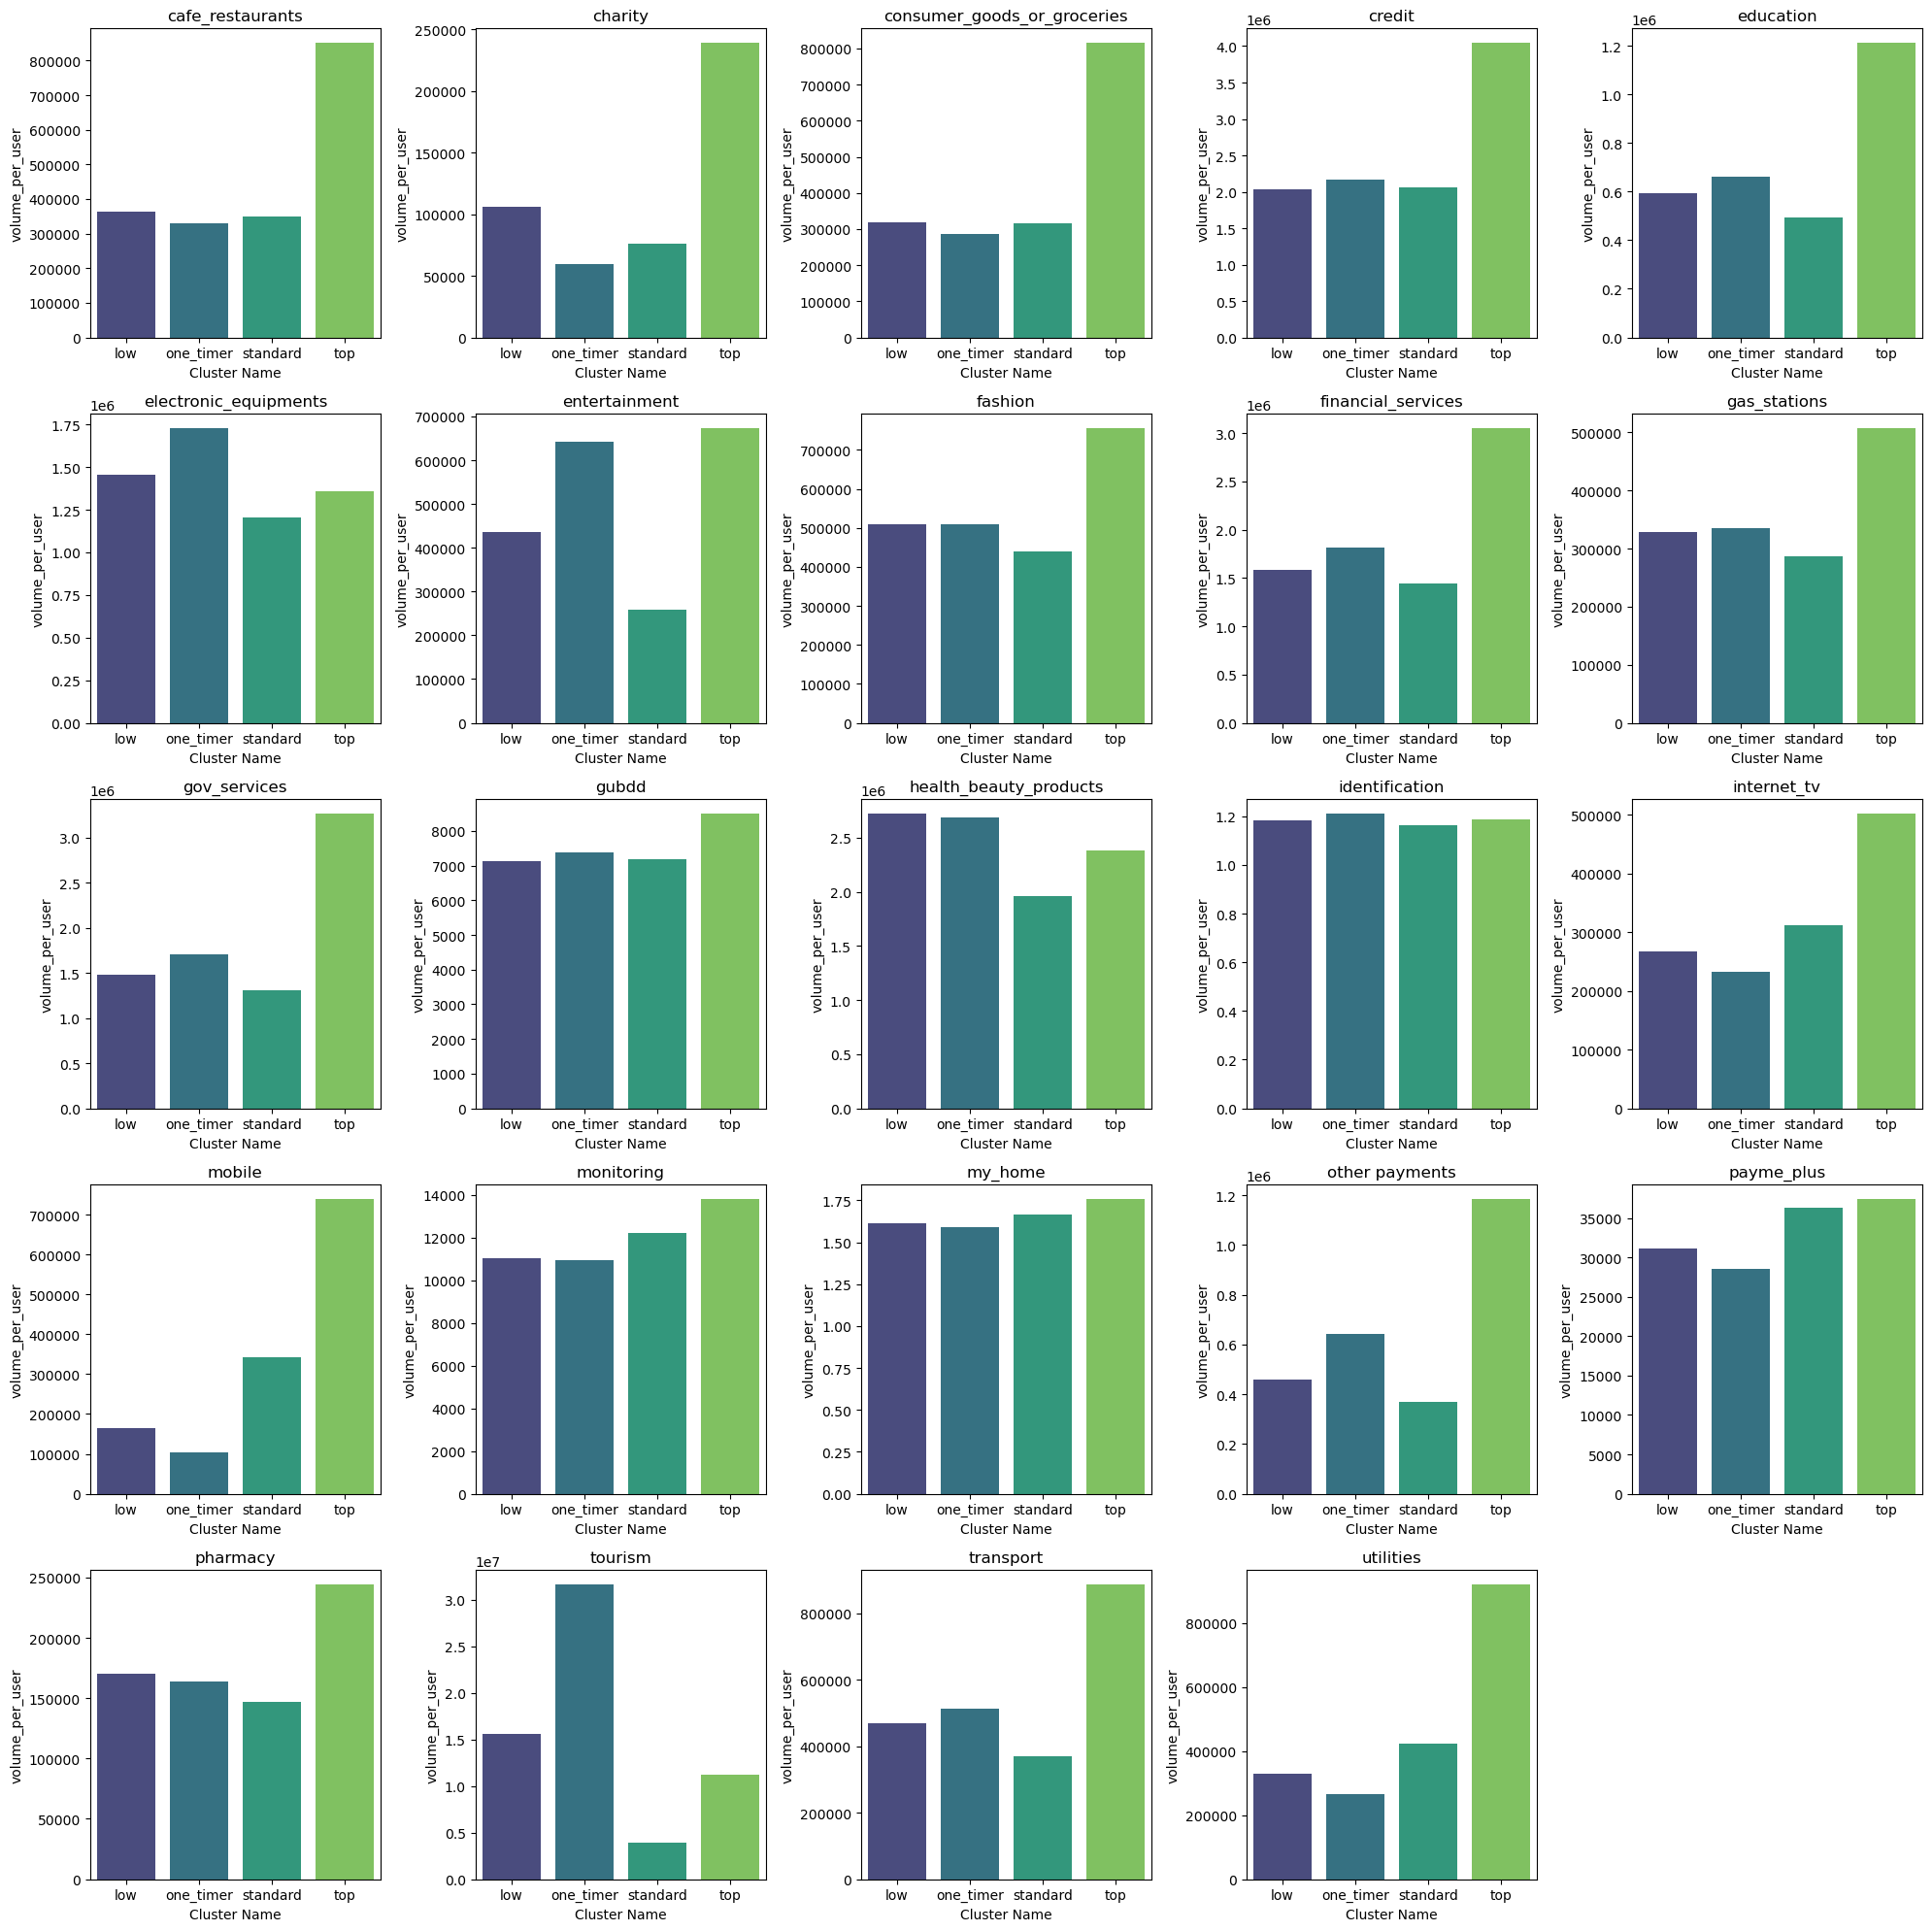

In [70]:
tr_types = tran_cl_grouped['tr_type'].unique()

# Number of subplots
num_tr_types = len(tr_types)
rows = (num_tr_types + 4) // 5  # Adjust rows dynamically for 5 columns
cols = 5  # Set columns to 5

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows), constrained_layout=True)
axes = axes.flatten()  # Flatten to easily iterate

# Plot each tr_type
for i, tr_type in enumerate(tr_types):
    ax = axes[i]
    data = tran_cl_grouped[tran_cl_grouped['tr_type'] == tr_type]
    sns.barplot(
        data=data,
        x='cluster_name',
        y='volume_per_user',
        ax=ax,
        palette = 'viridis'
    )
    ax.set_title(tr_type)
    ax.set_xlabel('Cluster Name')
    ax.set_ylabel('volume_per_user')

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Final adjustments
plt.tight_layout()
plt.show()

In [78]:
p2p_tran = pd.read_sql("""
        select * from payme_sandbox.p2p_user_activation_transactions_with_p2p
""", con = conn)

C:\Users\MSI\AppData\Local\Temp\ipykernel_27976\1763041152.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  p2p_tran = pd.read_sql("""


In [80]:
p2p_tran_cl = pd.merge(p2p_tran, clusters[['payer_id', 'cluster_name']], how = 'inner', on = 'payer_id')
p2p_tran_cld = pd.get_dummies(p2p_tran_cl, columns=['cluster_name'], dtype = 'int')
p2p_tran_cld['cluster_name'] = p2p_tran_cl['cluster_name']
p2p_tran_cl.sort_values(['payer_id', 'rn'], inplace = True)

In [81]:
p2p_tran_cl2 = p2p_tran_cl[p2p_tran_cl['rn'] < 5]
p2p_tran_cl2_gr = p2p_tran_cl2.groupby('payer_id')['tr_type'].apply(lambda x: ' -> '.join(x)).reset_index()
p2p_tran_cl2_gr = p2p_tran_cl2_gr.merge(clusters[['payer_id', 'cluster_name']], how = 'inner', on = 'payer_id')

In [83]:
p2p_tran_cl2_gr[p2p_tran_cl2_gr['cluster_name'] == 'top'].groupby('tr_type')['payer_id'].count().reset_index().sort_values('payer_id', ascending = False)

,tr_type,payer_id
5423,p2p,4404
6540,p2p -> mobile,3916
6801,p2p -> mobile -> monitoring -> utilities,2175
6894,p2p -> mobile -> utilities -> monitoring,1950
6878,p2p -> mobile -> utilities,1767
...,...,...
3287,mobile -> financial_services -> p2p -> transport,1
3286,mobile -> financial_services -> p2p -> other p...,1
3285,mobile -> financial_services -> p2p -> my_home,1
3280,mobile -> financial_services -> p2p -> electro...,1


In [93]:
p2p_tran_cl[p2p_tran_cl.payer_id == '65ec128c1aa434f7b471a69b']

,payer_id,create_time,tr_type,amount,days_after_registration,rn,cluster_name
4917307,65ec128c1aa434f7b471a69b,2024-03-14 13:47:42.421000+00:00,p2p,4935000.0,5.0,1,top


In [95]:
clusters[clusters.payer_id == '65ec128c1aa434f7b471a69b']

,payer_id,mean_days,median_days,std_days,min_days,max_days,count_days,skew_days,kurtosis_days,q25_days,...,mean_amount,median_amount,count_trn,sum_amount,std_amount,median_gap,iqr,variation,cluster,cluster_name
1605607,65ec128c1aa434f7b471a69b,5.257806,5.258806,0.002789,5.254655,5.259957,1,-1.405968,0.0,5.25673,...,1645000.0,30000.0,3,4935000.0,2.818940e+06,0.002651,0.002651,0.005289,3,top


In [91]:
p2p_tran_cl[p2p_tran_cl['cluster_name'] == 'top'].groupby('payer_id')['rn'].max().reset_index().sort_values('rn').head(10)

,payer_id,rn
109368,65ec128c1aa434f7b471a69b,1
43654,65087b901fc661974a67a6a0,1
6924,646c9dca632f1eba47d42246,1
22829,64b212b235b2168a959f5f7d,1
32565,64dbab32623911e599e88b7c,1
6916,646c99657b6dcade8b975276,1
43645,6508770f088faf77f3020789,1
25800,64c0eb98617d5684547205cc,1
43642,650874e9620872ea4a5afa12,1
85416,659f598ba9d99553fd9cc207,1


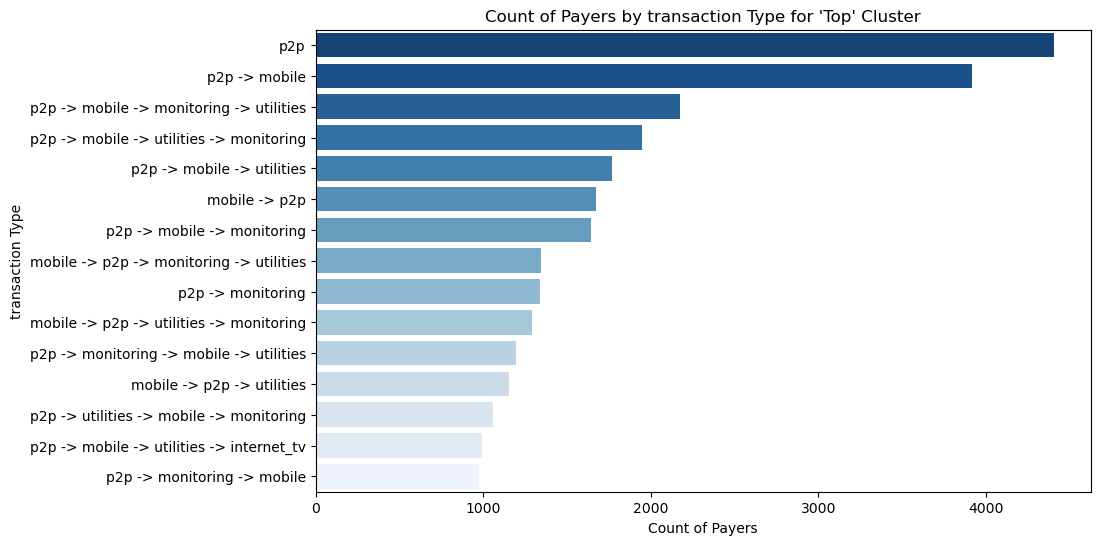

In [84]:
# Aggregating the data
top_data = p2p_tran_cl2_gr[p2p_tran_cl2_gr['cluster_name'] == 'top'].groupby('tr_type')['payer_id'].count().reset_index()

# Sorting values
top_data = top_data.sort_values('payer_id', ascending=False).head(15)

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='payer_id', y='tr_type', data=top_data, palette='Blues_r')

# Adding labels and title
plt.xlabel("Count of Payers")
plt.ylabel("transaction Type")
plt.title("Count of Payers by transaction Type for 'Top' Cluster")

# Show the plot
plt.show()